# Data Cleaning and Preprocessing 

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the dataset
file_path = "Final_data.csv"
df = pd.read_csv(file_path)

# Assign proper column names based on the second row and remove irrelevant rows
df_cleaned = df.iloc[2:].reset_index(drop=True)
df_cleaned.columns = [
    "S.no.", "Volunteer", "Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
    "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz", "Speed_km_hr"
]

# Convert numerical columns to appropriate data types
num_cols = df_cleaned.columns[2:]  # Exclude S.no. and Volunteer
df_cleaned[num_cols] = df_cleaned[num_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
df_cleaned = df_cleaned.dropna().reset_index(drop=True)

# Save the cleaned dataset
df_cleaned.to_csv("Final_data_cleaned.csv", index=False)

# Normalize the data
features = ["Speed_km_hr", "Volunteer"]
targets = ["Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
           "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df_cleaned[features])
Y_scaled = scaler_Y.fit_transform(df_cleaned[targets])

# Prepare LSTM sequences
sequence_length = 10  # Using past 10 data points for prediction
X_sequences, Y_sequences = [], []

for i in range(len(df_cleaned) - sequence_length):
    X_sequences.append(X_scaled[i:i + sequence_length])
    Y_sequences.append(Y_scaled[i + sequence_length])  # Predict next point

X_sequences = np.array(X_sequences)
Y_sequences = np.array(Y_sequences)

# Split into training and testing sets
split_idx = int(0.8 * len(X_sequences))
X_train, X_test = X_sequences[:split_idx], X_sequences[split_idx:]
Y_train, Y_test = Y_sequences[:split_idx], Y_sequences[split_idx:]

print("Data cleaning and formatting completed. Ready for LSTM model.")


Data cleaning and formatting completed. Ready for LSTM model.


# LSTM Model 

Epoch 1/100


C:\Users\rishi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


785/785 ━━━━━━━━━━━━━━━━━━━━ 52s 60ms/step - loss: 0.0122 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 2/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - loss: 0.0014 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 3/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - loss: 0.0010 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - loss: 8.0712e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 5/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - loss: 7.3101e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 6/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - loss: 6.2651e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 7/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - loss: 5.5729e-04 - val_loss: 9.1539e-04 - learning_rate: 0.0010
Epoch 8/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - loss: 5.0808e-04 - val_loss: 8.8369e-04 - learning_rate: 0.0010
Epoch 9/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - loss: 4.8633e-04 - val_

Model saved successfully!
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Mean Squared Error (MSE): 0.9827
Mean Absolute Error (MAE): 0.5072
R² Score: 0.9041

--- Classification-like Metrics (after binarizing) ---
Accuracy: 0.9345
Precision (Specificity): 0.9374
Recall (Sensitivity): 0.8568
F1 Score: 0.8953

Total training time: 3534.38 seconds


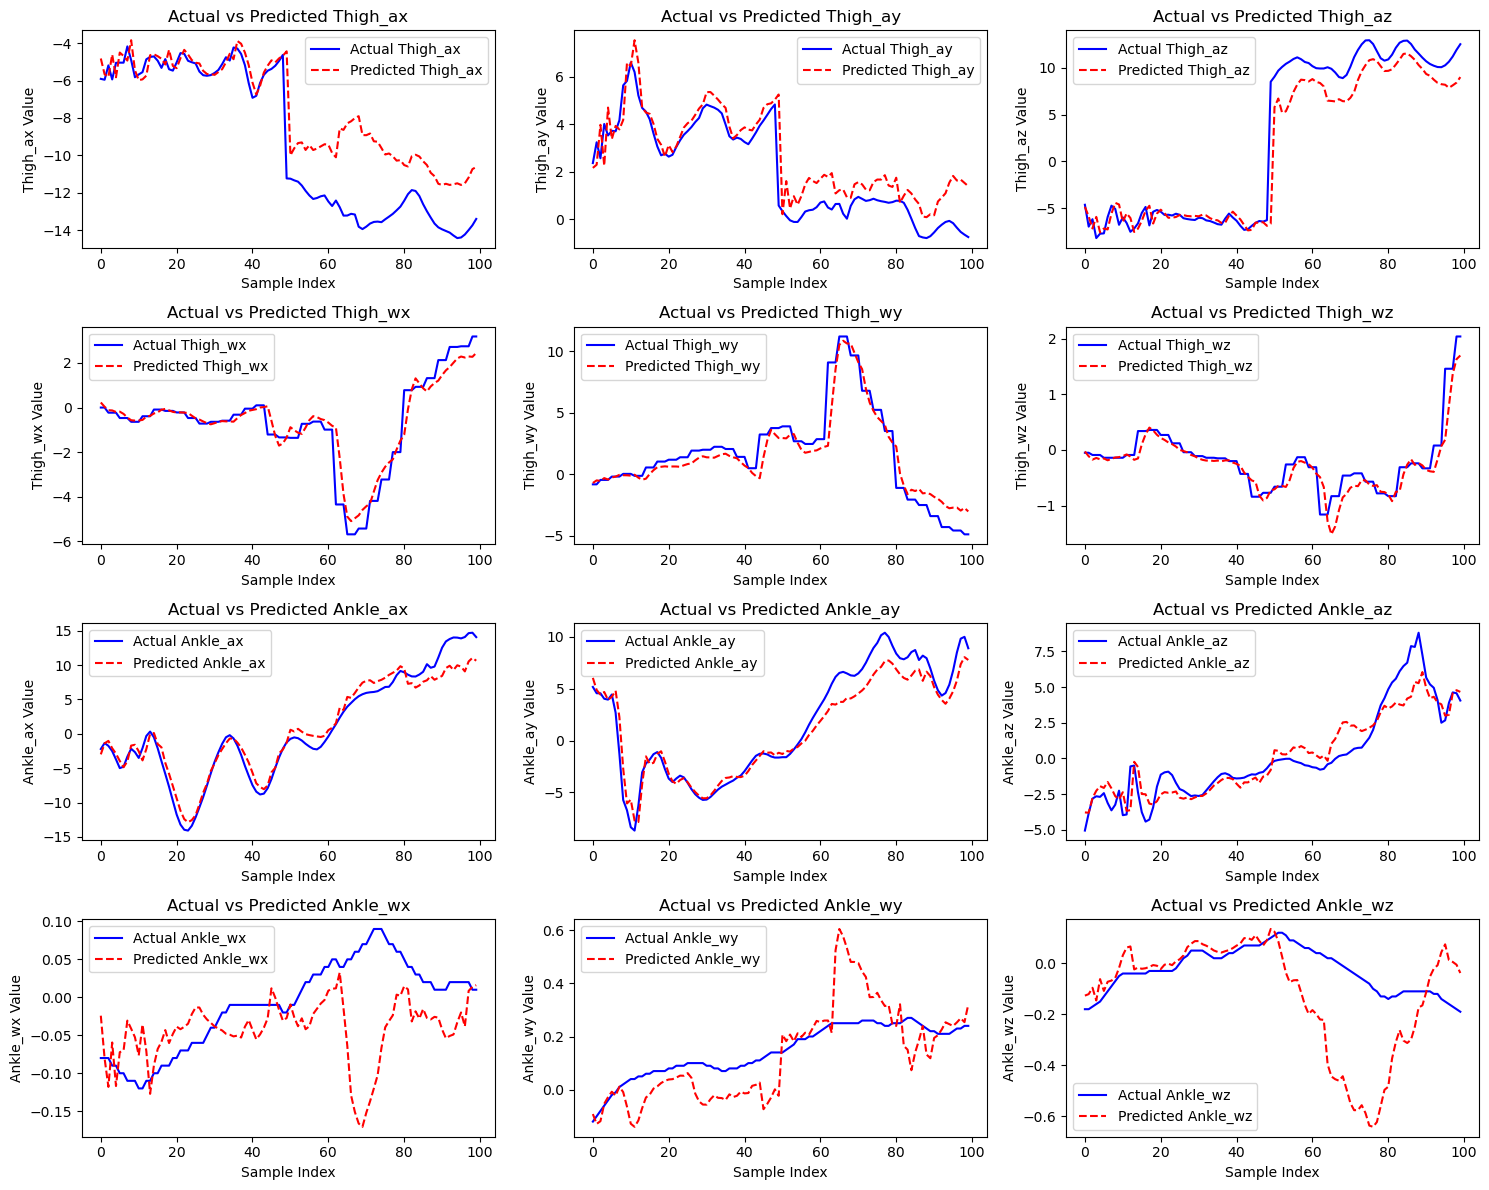

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import time

# Load the cleaned dataset
file_path = "Final_data_cleaned.csv"  # Update if needed
df = pd.read_csv(file_path)

# Selecting more features (independent variables) & targets (dependent variables)
features = ["Speed_km_hr", "Volunteer", 
            "Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
            "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

targets = ["Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
           "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

# Normalize the dataset
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
Y_scaled = scaler_Y.fit_transform(df[targets])

# Define sequence length for LSTM (using past 30 timesteps to predict the next)
sequence_length = 30
X_sequences, Y_sequences = [], []

for i in range(len(df) - sequence_length):
    X_sequences.append(X_scaled[i:i + sequence_length])
    Y_sequences.append(Y_scaled[i + sequence_length])  # Predict the next point

X_sequences = np.array(X_sequences)
Y_sequences = np.array(Y_sequences)

# Splitting into training and testing sets (80% train, 20% test)
split_idx = int(0.8 * len(X_sequences))
X_train, X_test = X_sequences[:split_idx], X_sequences[split_idx:]
Y_train, Y_test = Y_sequences[:split_idx], Y_sequences[split_idx:]

# Define an improved LSTM model
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(sequence_length, len(features))),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(12)  # 12 output values (gyroscope & accelerometer x, y, z)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Callbacks for learning rate scheduling & early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model for 100 epochs
# Train model with timer
start_time = time.time()
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), 
                    verbose=1, callbacks=[lr_scheduler, early_stopping])

end_time = time.time()
train_time = end_time - start_time

# Save the trained model
model.save("lstm_sensor_model.h5")
print("Model saved successfully!")

# Predict values on test set
Y_pred = model.predict(X_test)

# Inverse transform to get actual values
Y_test_actual = scaler_Y.inverse_transform(Y_test)
Y_pred_actual = scaler_Y.inverse_transform(Y_pred)

# Evaluate the model using regression metrics
mse = mean_squared_error(Y_test_actual, Y_pred_actual)
mae = mean_absolute_error(Y_test_actual, Y_pred_actual)
r2 = r2_score(Y_test_actual, Y_pred_actual)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# ------------------ BINARIZED CLASSIFICATION-LIKE METRICS ------------------
threshold = 0.5  # example threshold
Y_pred_bin = (Y_pred_actual > threshold).astype(int)
Y_test_bin = (Y_test_actual > threshold).astype(int)

# Flatten arrays to compute metrics
Y_pred_flat = Y_pred_bin.flatten()
Y_test_flat = Y_test_bin.flatten()

accuracy = accuracy_score(Y_test_flat, Y_pred_flat)
precision = precision_score(Y_test_flat, Y_pred_flat, zero_division=0)
recall = recall_score(Y_test_flat, Y_pred_flat, zero_division=0)
f1 = f1_score(Y_test_flat, Y_pred_flat, zero_division=0)

print("\n--- Classification-like Metrics (after binarizing) ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Specificity): {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ------------------ COMPUTATIONAL COST ------------------
print(f"\nTotal training time: {train_time:.2f} seconds")


# Plot actual vs predicted values for one of the output variables (Thigh_ax)
plt.figure(figsize=(15, 12))

# Loop through all target variables
for i in range(len(targets)):
    plt.subplot(4, 3, i + 1)  # 4 rows, 3 columns (since we have 12 targets)
    plt.plot(Y_test_actual[:100, i], label=f"Actual {targets[i]}", color='blue')
    plt.plot(Y_pred_actual[:100, i], label=f"Predicted {targets[i]}", color='red', linestyle='dashed')
    plt.xlabel("Sample Index")
    plt.ylabel(f"{targets[i]} Value")
    plt.legend()
    plt.title(f"Actual vs Predicted {targets[i]}")

plt.tight_layout()
plt.show()



# Wavenet Model


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 30, 14)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 30, 64)            │             960 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 30, 64)            │           8,256 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 30, 64)            │           8,256 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 30, 64)            │               0 │ conv1d_1[0][0],            │
│                               │                           │                 │ conv1d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 30, 64)            │           4,160 │ multiply[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 30, 64)            │               0 │ conv1d_3[0][0],            │
│                               │                           │                 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 30, 64)            │           8,256 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)             │ (None, 30, 64)            │           8,256 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_1 (Multiply)         │ (None, 30, 64)            │               0 │ conv1d_4[0][0],            │
│                               │                           │                 │ conv1d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_6 (Conv1D)             │ (None, 30, 64)            │           4,160 │ multiply_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 30, 64)            │               0 │ conv1d_6[0][0], add[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_7 (Conv1D)             │ (None, 30, 64)            │           8,256 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_8 (Conv1D)             │ (None, 30, 64)            │           8,256 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_2 (Multiply)         │ (None, 30, 64)            │               0 │ conv1d_7[0][0],            │
│                               │                           │                 │ conv1d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 129,932 (507.55 KB)

 Trainable params: 129,932 (507.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0091 - val_loss: 9.2297e-04 - learning_rate: 0.0010
Epoch 2/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 3.4315e-04 - val_loss: 5.6116e-04 - learning_rate: 0.0010
Epoch 3/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 2.4015e-04 - val_loss: 3.7350e-04 - learning_rate: 0.0010
Epoch 4/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.0239e-04 - val_loss: 4.2352e-04 - learning_rate: 0.0010
Epoch 5/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 1.8467e-04 - val_loss: 3.7207e-04 - learning_rate: 0.0010
Epoch 6/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 1.7106e-04 - val_loss: 3.3043e-04 - learning_rate: 0.0010
Epoch 7/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 1.6323e-04 - val_loss: 3.1966e-04 - learning_rate: 0.0010
Epoch 8/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6699e-04
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
785/785 

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean Squared Error (MSE): 0.6127
Mean Absolute Error (MAE): 0.3382
R² Score: 0.9396
 Accuracy (binarized): 0.9511
 Precision: 0.9092
 Recall (Sensitivity): 0.9447
 F1 Score: 0.9266
 Specificity: 0.9542
 Computational Cost (Training Time): 502.95 seconds


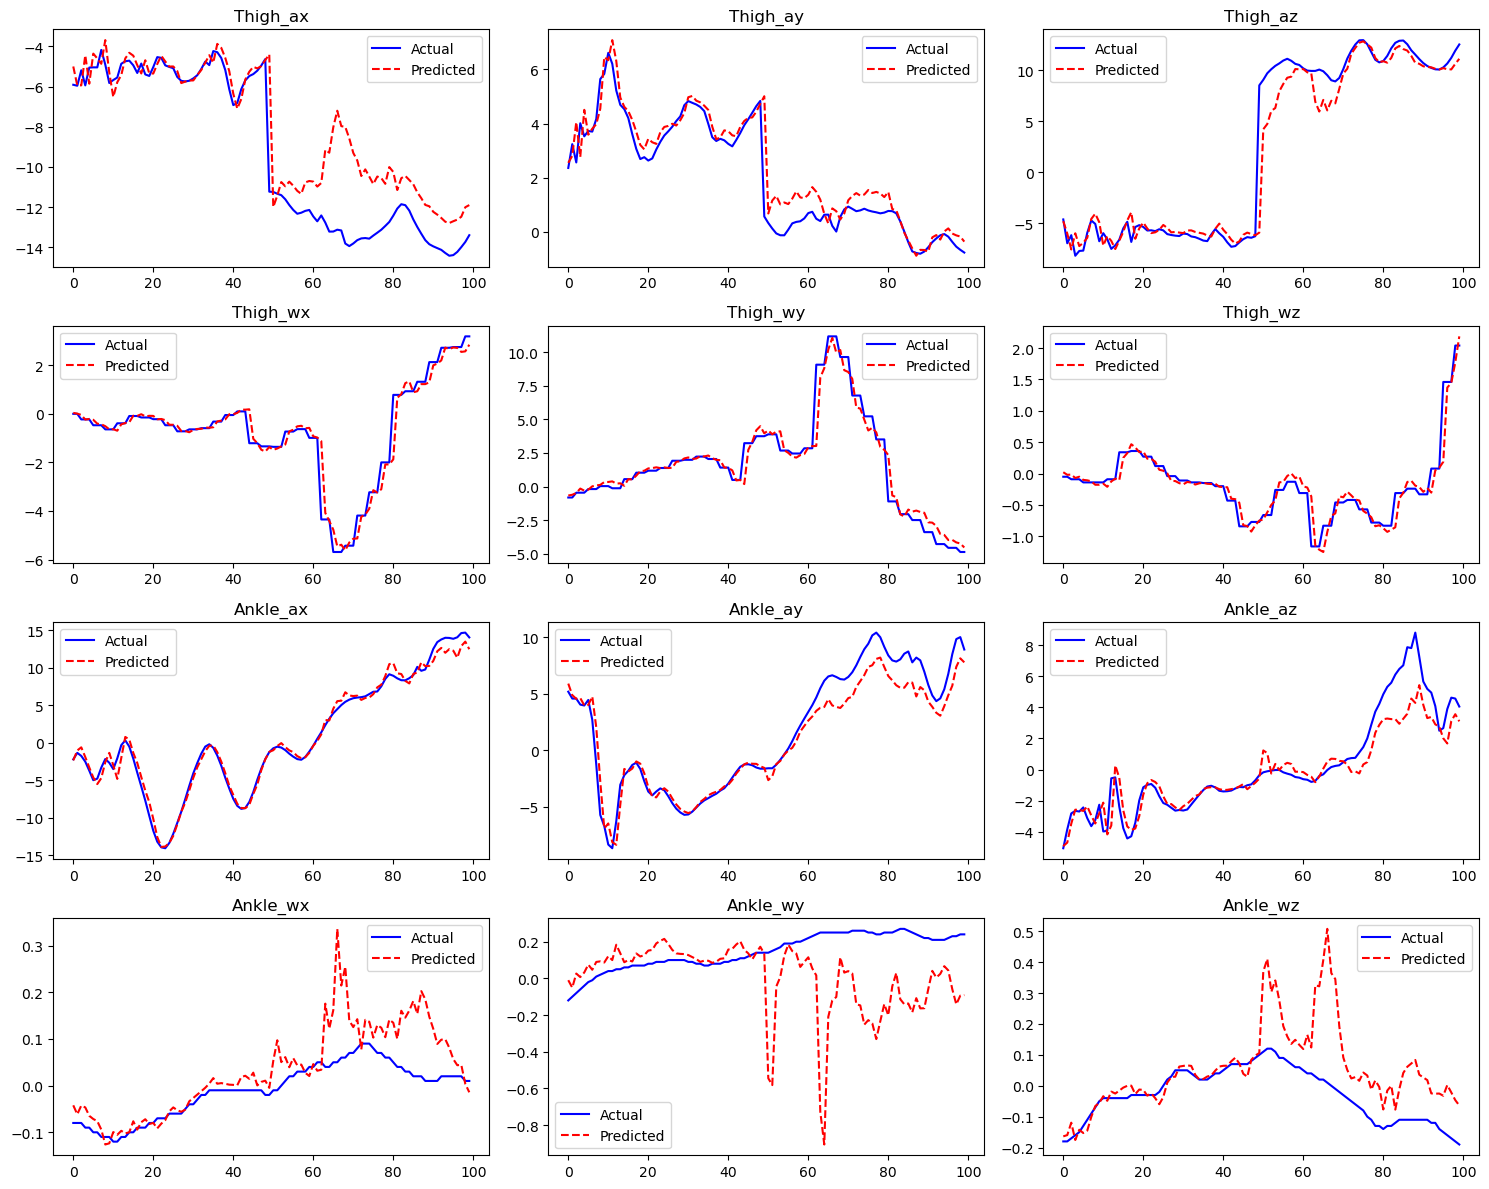

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import time

# Load your dataset
df = pd.read_csv("Final_data_cleaned.csv")

# Define features and targets
features = ["Speed_km_hr", "Volunteer", 
            "Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
            "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

targets = ["Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
           "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

# Scale data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
Y_scaled = scaler_Y.fit_transform(df[targets])

# Create sequences
seq_len = 30
X_seq, Y_seq = [], []
for i in range(len(df) - seq_len):
    X_seq.append(X_scaled[i:i+seq_len])
    Y_seq.append(Y_scaled[i+seq_len])
X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)

# Split data
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
Y_train, Y_test = Y_seq[:split], Y_seq[split:]

# Define residual block
def residual_block(x, dilation_rate, filters, kernel_size):
    prev_x = x
    tanh_out = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='tanh')(x)
    sigm_out = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='sigmoid')(x)
    merged = tf.keras.layers.Multiply()([tanh_out, sigm_out])
    skip_out = Conv1D(filters, 1)(merged)
    res_out = Add()([skip_out, prev_x])
    return res_out, skip_out

# Build WaveNet model
inputs = Input(shape=(seq_len, len(features)))
x = Conv1D(64, kernel_size=1, padding='causal')(inputs)

skips = []
for d in [1, 2, 4, 8, 16, 32]:
    x, skip = residual_block(x, d, 64, 2)
    skips.append(skip)

x = Add()(skips)
x = Activation('relu')(x)
x = Conv1D(64, 1, activation='relu')(x)
x = Conv1D(len(targets), 1)(x)
x = Lambda(lambda t: t[:, -1, :])(x)

model = Model(inputs, x)
model.compile(optimizer='adam', loss='mse')
model.summary()

# Callbacks
lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train model
# --- Measure computational cost ---
start_time = time.time()
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test),
                    callbacks=[lr, es])

training_time = time.time() - start_time

# Save model
model.save("wavenet_sensor_model.h5")

# Evaluate
Y_pred = model.predict(X_test)
Y_pred_actual = scaler_Y.inverse_transform(Y_pred)
Y_test_actual = scaler_Y.inverse_transform(Y_test)

mse = mean_squared_error(Y_test_actual, Y_pred_actual)
mae = mean_absolute_error(Y_test_actual, Y_pred_actual)
r2 = r2_score(Y_test_actual, Y_pred_actual)

# --- Simulated Classification Metrics (Optional) ---
# Thresholding to convert regression to binary (e.g., movement vs no movement)
threshold = 0.5
Y_pred_bin = (Y_pred_actual > threshold).astype(int)
Y_test_bin = (Y_test_actual > threshold).astype(int)

# Flatten for metrics
Y_pred_flat = Y_pred_bin.flatten()
Y_test_flat = Y_test_bin.flatten()

accuracy = accuracy_score(Y_test_flat, Y_pred_flat)
precision = precision_score(Y_test_flat, Y_pred_flat, zero_division=0)
recall = recall_score(Y_test_flat, Y_pred_flat, zero_division=0)
f1 = f1_score(Y_test_flat, Y_pred_flat, zero_division=0)
tn, fp, fn, tp = confusion_matrix(Y_test_flat, Y_pred_flat).ravel()
specificity = tn / (tn + fp)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f" Accuracy (binarized): {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall (Sensitivity): {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" Specificity: {specificity:.4f}")
print(f" Computational Cost (Training Time): {training_time:.2f} seconds")

# Plot predictions vs actual
plt.figure(figsize=(15, 12))
for i, label in enumerate(targets):
    plt.subplot(4, 3, i + 1)
    plt.plot(Y_test_actual[:100, i], label='Actual', color='blue')
    plt.plot(Y_pred_actual[:100, i], label='Predicted', color='red', linestyle='--')
    plt.title(label)
    plt.legend()
plt.tight_layout()
plt.show()


# Alternative method for Wavenet Model

---

## Model Architecture

### Input
- **Shape:** The model expects input data with shape `(1, number_of_features)` after reshaping to fit the 1D convolutional architecture.
- **Features:** The input features include gait speed (`Speed_km_hr`), volunteer identifier (`Volunteer`), and various IMU signals from the thigh and ankle (accelerometer and gyroscope components).

### WaveNet Blocks
The primary component of the model consists of multiple WaveNet residual blocks, each comprising:
1. Two parallel one-dimensional convolutional layers:
   - One using the hyperbolic tangent (`tanh`) activation function.
   - One using the sigmoid (`sigmoid`) activation function.
2. Element-wise addition of the outputs to emulate a gating mechanism.
3. A skip connection is generated for each block to facilitate gradient flow during training.
4. A residual connection adds the block’s output back to the original input to preserve sequential information.

### Dilation Strategy
- The model uses a sequence of dilation rates `[1, 2, 4, 8]` across the WaveNet blocks.
- Dilation enables the model to expand its receptive field exponentially with depth, allowing it to capture dependencies over various temporal scales.
- Causal padding ensures that predictions at time step *t* are only influenced by time steps *≤ t*, maintaining the temporal integrity required for sequence prediction.

### Skip Connection Aggregation
- All skip connections from the WaveNet blocks are summed and passed through:
  - A Rectified Linear Unit (ReLU) activation function.
  - A 1×1 convolutional layer with 64 filters.
  - Another 1×1 convolutional layer projecting the output to match the target dimensionality.

### Output Layer
- The output is flattened to produce a vector matching the number of target parameters.
- The final output consists of 12 values corresponding to predicted IMU signal components.

---

## Model Training and Evaluation

### Training Procedure
- **Input:** Standardized input features including gait speed, volunteer ID, and sensor readings.
- **Target:** Standardized output vectors of thigh and ankle IMU measurements.
- The model is trained using the Mean Squared Error (MSE) loss function and optimized with the Adam optimizer.
- A validation split of 10% of the training data is used to monitor the model's performance during training.

### Prediction and Metrics
- Predictions on the test dataset are inverse-transformed to the original scale.
- The model’s predictive performance is evaluated using:
  - **Mean Squared Error (MSE)**
  - **Mean Absolute Error (MAE)**
  - **Coefficient of Determination (R² Score)**

These metrics are computed individually for each of the 12 target variables to assess the model's accuracy and generalization.

### Visualization
- Line plots comparing actual and predicted values are generated for each target variable to provide a visual assessment of the model’s performance.

---

## Justification for Using WaveNet
- WaveNet employs dilated causal convolutions, which allow the model to effectively model long-range dependencies in sequential data without relying on recurrent structures.
- This enables the network to maintain a large receptive field while keeping the number of layers and parameters manageable.
- Originally designed for applications in speech synthesis, WaveNet architectures have shown strong performance in a variety of time-series forecasting tasks, making them suitable for modeling biomechanical and sensor data.

---

## Summary
The implemented WaveNet-based model effectively learns complex, time-dependent relationships in lower limb sensor data. Its architecture, which leverages dilated convolutions, residual and skip connections, and causal structures, allows for accurate multi-target regression. This approach demonstrates the feasibility and effectiveness of deep convolutional models for predictive modeling in human gait analysis and related biomedical signal processing applications.
t powerful for tasks like IMU signal forecasting and gait analysis.


Epoch 1/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 0.1794 - mae: 0.2067 - val_loss: 0.0093 - val_mae: 0.0589
Epoch 2/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0087 - mae: 0.0605 - val_loss: 0.0135 - val_mae: 0.0729
Epoch 3/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0077 - mae: 0.0553 - val_loss: 0.0046 - val_mae: 0.0478
Epoch 4/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0044 - mae: 0.0424 - val_loss: 0.0035 - val_mae: 0.0426
Epoch 5/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0035 - mae: 0.0372 - val_loss: 0.0024 - val_mae: 0.0317
Epoch 6/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0054 - mae: 0.0457 - val_loss: 0.0040 - val_mae: 0.0434
Epoch 7/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0035 - mae: 0.0386 - val_loss: 0.0049 - val_mae: 0.0479
Epoch 8/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0025 - mae: 0.0322 - val_loss: 0.0025 - val_mae: 0.0295
Epoch 9/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms

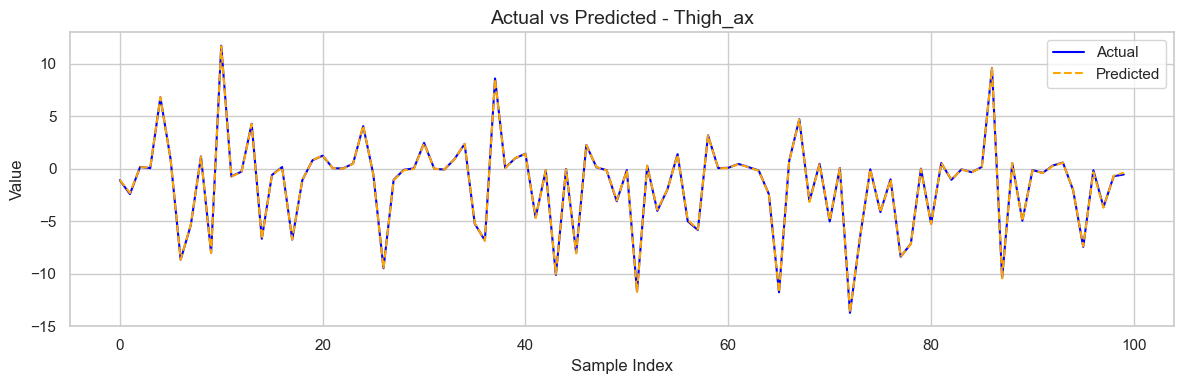

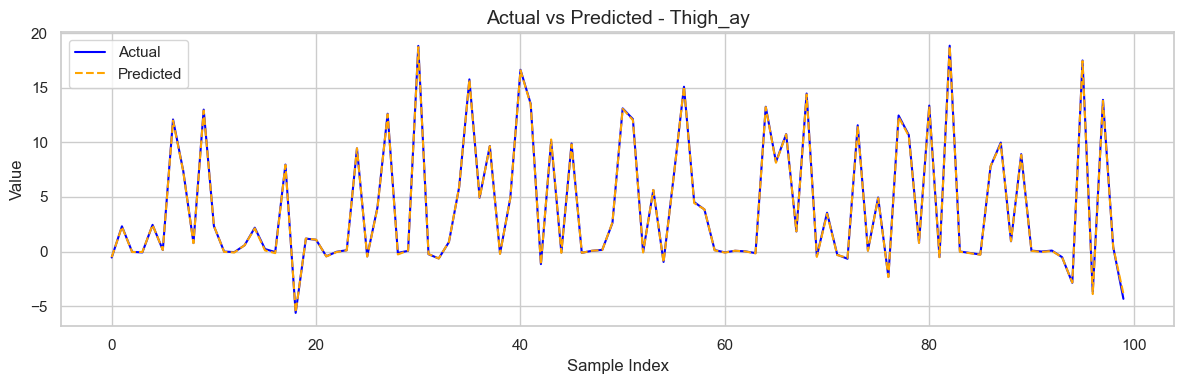

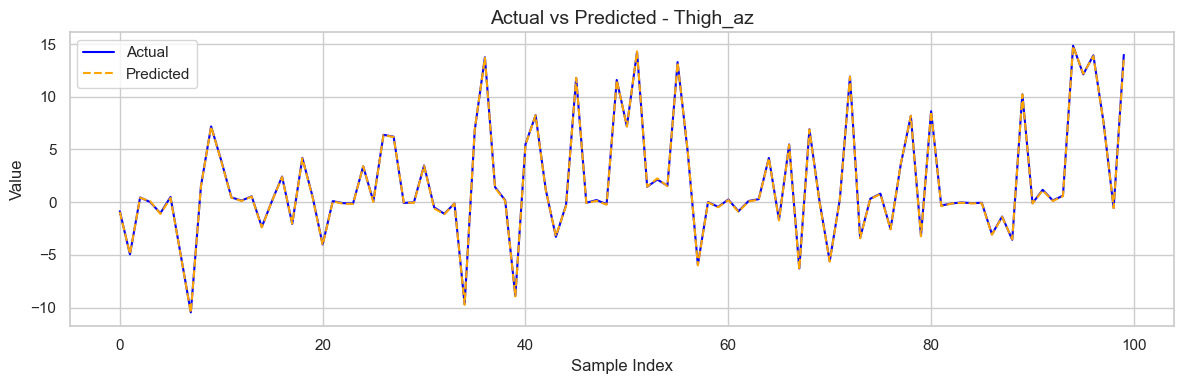

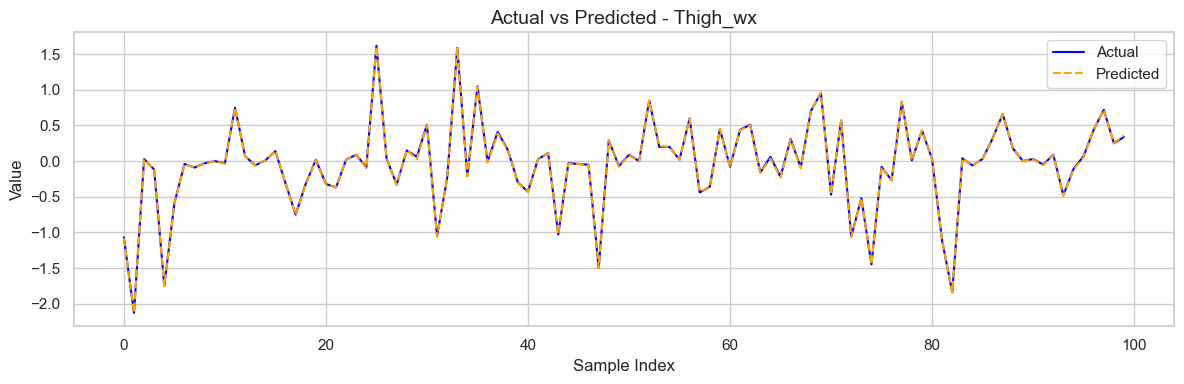

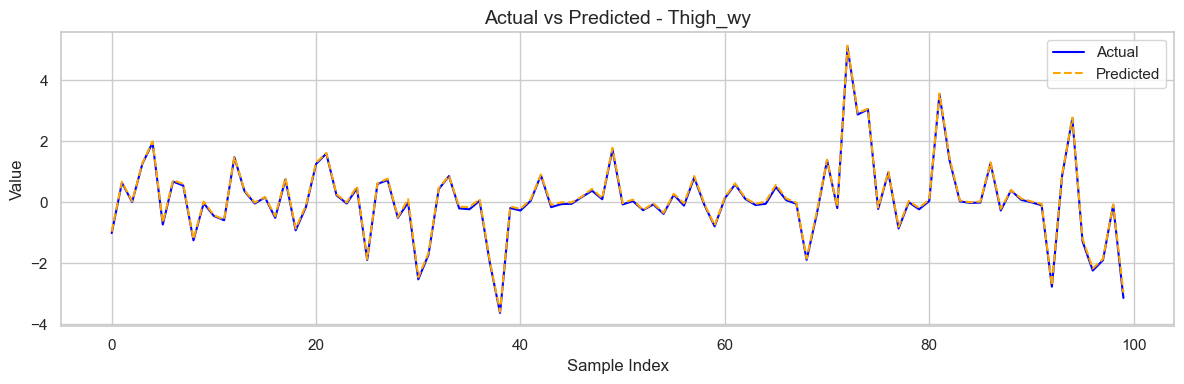

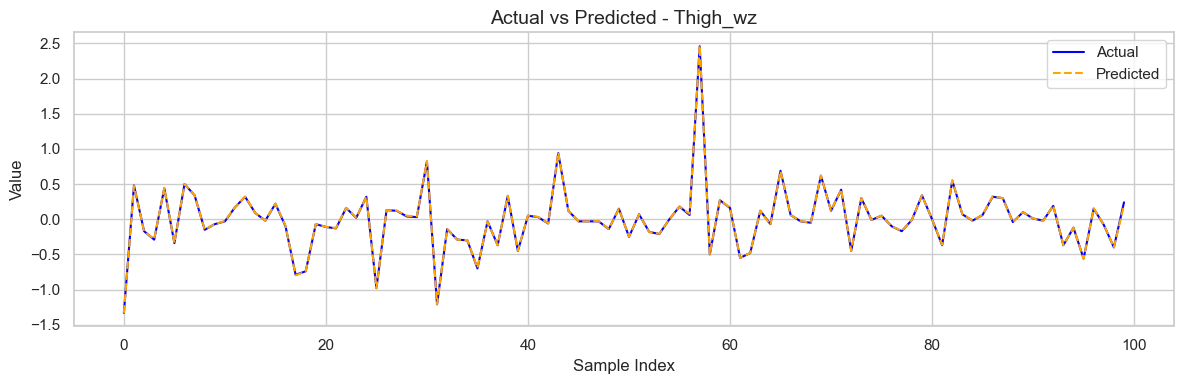

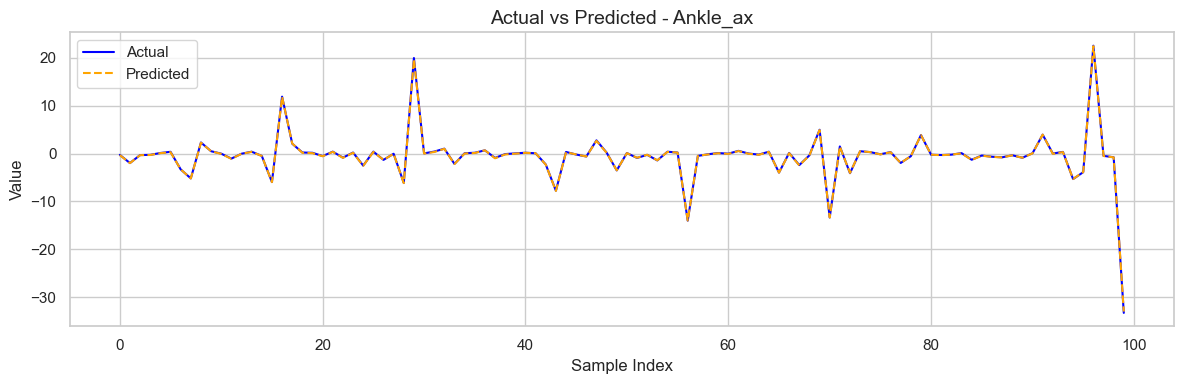

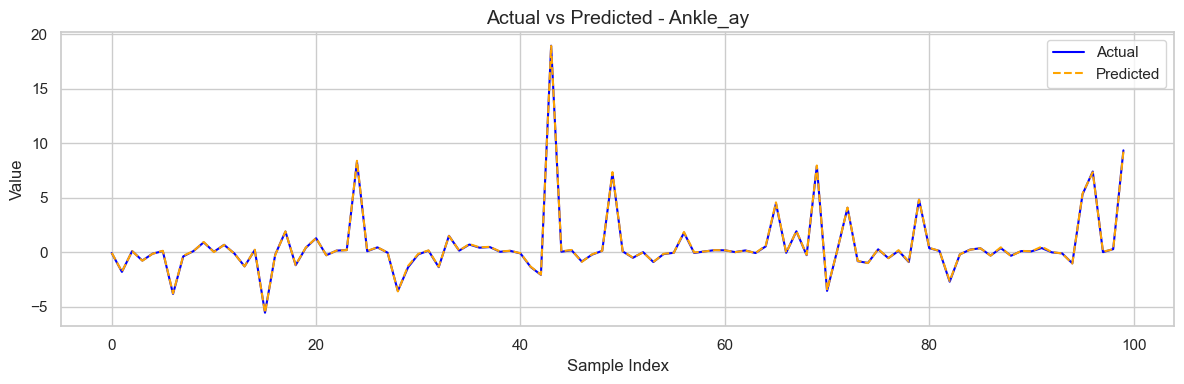

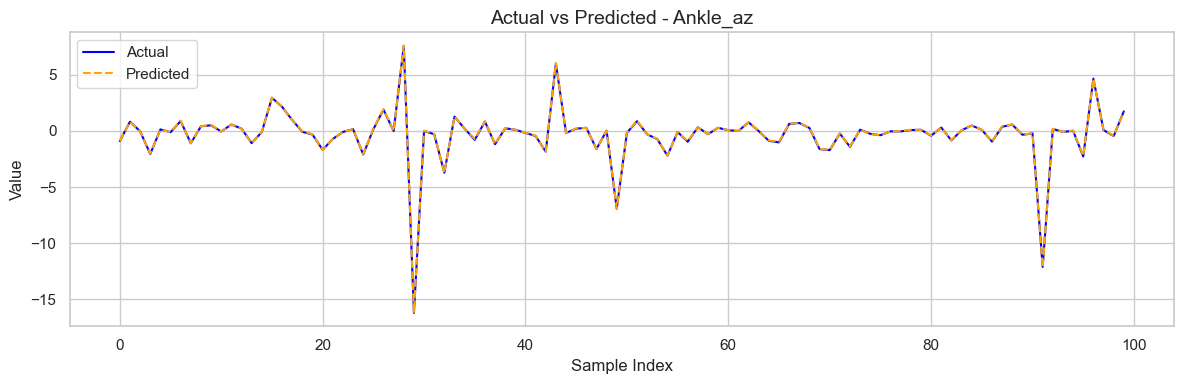

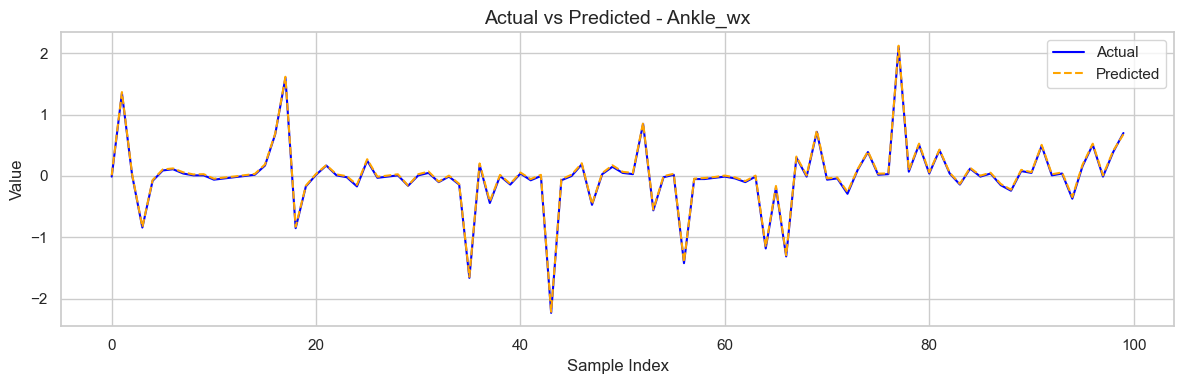

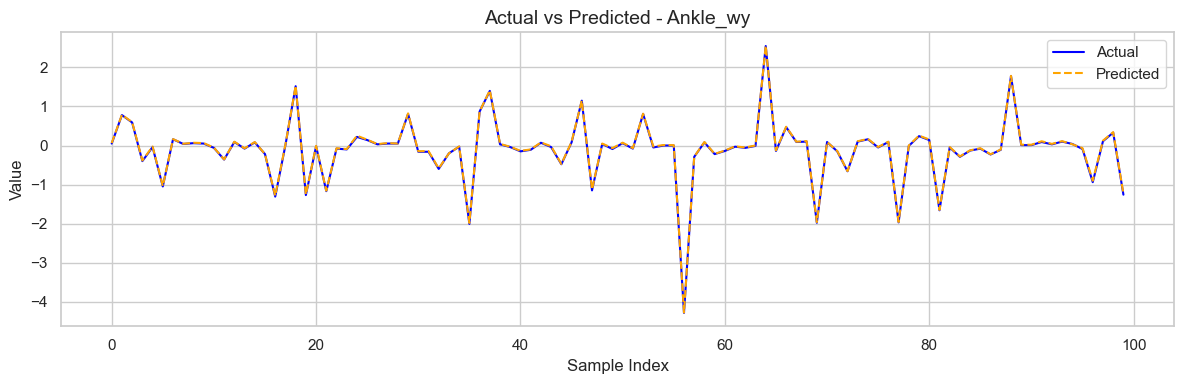

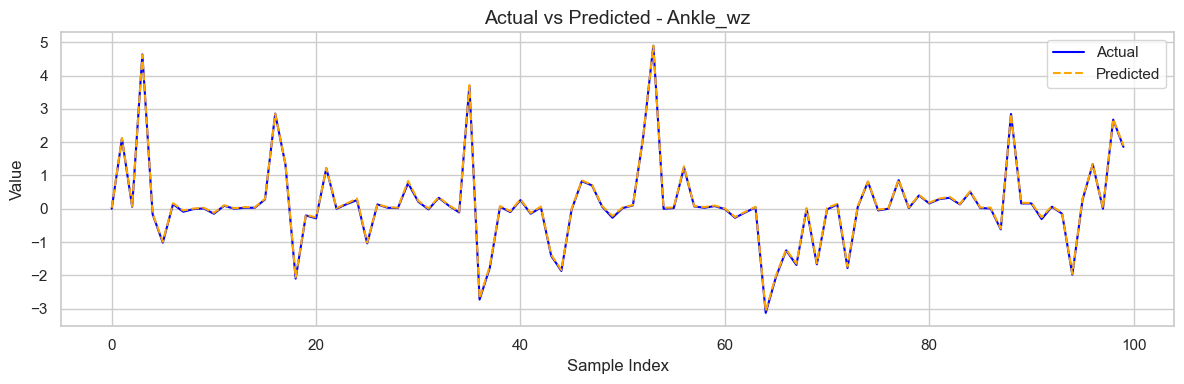

In [8]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 📥 Load dataset
df = pd.read_csv('Final_data_cleaned.csv')

# 🎯 Feature and target columns
features = ["Speed_km_hr", "Volunteer", 
            "Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
            "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

targets = ["Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
           "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

# 🧼 Prepare data
X = df[features].values
y = df[targets].values

# Standardizing
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# 📚 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input for 1D convolution
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 🔁 WaveNet block (with shape fix)
def wavenet_block(inputs, dilation_rate, filters, kernel_size):
    tanh_out = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='tanh')(inputs)
    sigm_out = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='sigmoid')(inputs)
    merged = Add()([tanh_out, sigm_out])
    skip_out = Conv1D(filters, 1)(merged)
    residual = Conv1D(filters, 1)(inputs)  # shape match
    return Add()([residual, skip_out]), skip_out

# 🧠 Build WaveNet model
def build_wavenet_model(input_shape, output_dim):
    inputs = Input(shape=input_shape)
    x = inputs
    skip_connections = []

    for dilation_rate in [1, 2, 4, 8]:
        x, skip = wavenet_block(x, dilation_rate, filters=64, kernel_size=2)
        skip_connections.append(skip)

    x = Add()(skip_connections)
    x = Activation('relu')(x)
    x = Conv1D(64, 1, activation='relu')(x)
    x = Conv1D(output_dim, 1)(x)
    x = Flatten()(x)

    model = Model(inputs, x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# 🚀 Train model
model = build_wavenet_model(input_shape=(1, X_train.shape[2]), output_dim=y_train.shape[1])

# Save the trained model
model.save("wavenet_alternate_sensor_model.h5")
print("Model saved successfully!")

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# 🧮 Predictions
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_inv = y_scaler.inverse_transform(y_test)

# 📊 Per-target metrics
total_mse, total_mae, total_r2 = 0, 0, 0
print("\n📈 Per-Target Evaluation Metrics:\n")

for i, target in enumerate(targets):
    mse = mean_squared_error(y_test_inv[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test_inv[:, i], y_pred[:, i])
    r2 = r2_score(y_test_inv[:, i], y_pred[:, i])
    total_mse += mse
    total_mae += mae
    total_r2 += r2
    print(f"{target} ➤ MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# 📌 Final Average Metrics
n_targets = len(targets)
print("\n✅ Final Averaged Metrics Across All Targets:")
print(f"Average MSE: {total_mse / n_targets:.4f}")
print(f"Average MAE: {total_mae / n_targets:.4f}")
print(f"Average R² : {total_r2 / n_targets:.4f}")

sns.set(style="whitegrid")

# 📈 Line Plot: Actual vs Predicted (Line Graph for each target)
for i, target in enumerate(targets):
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_inv[:100, i], label='Actual', color='blue', linewidth=1.5)
    plt.plot(y_pred[:100, i], label='Predicted', color='orange', linestyle='--', linewidth=1.5)
    plt.title(f'Actual vs Predicted - {target}', fontsize=14)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

# GRU Model


## Overview
This implementation leverages a Gated Recurrent Unit (GRU) neural network for multivariate time series regression, designed to predict lower limb inertial measurement unit (IMU) sensor outputs. The GRU model is particularly suited for modeling sequential data due to its ability to retain long-term temporal dependencies while being computationally efficient.

---

## Model Architecture

### Input
- **Shape:** The input data is reshaped to `(samples, timesteps=1, features=14)` to suit the GRU input requirements.
- **Features:** The input features include:
  - Gait speed (`Speed_km_hr`)
  - Volunteer ID
  - Thigh and ankle IMU readings (accelerometer and gyroscope signals along 3 axes each)

### GRU Network
- **GRU Layer:**
  - A single GRU layer with 64 units.
  - Processes temporal patterns over time steps and compresses temporal features into hidden states.
  - `return_sequences=False` is used as the model outputs a single prediction per input instance.
- **Dense Layers:**
  - A fully connected Dense layer with 32 neurons and ReLU activation.
  - A final Dense output layer with 12 neurons corresponding to the 12 target IMU measurements.

---

## Model Training and Evaluation

### Data Preprocessing
- Input and target data are scaled using **MinMaxScaler** for effective training.
- After scaling, the input is reshaped to a 3D structure required for GRU models.

### Training Procedure
- The model is compiled with:
  - **Loss function:** Mean Squared Error (MSE)
  - **Optimizer:** Adam
- Training is performed for 50 epochs with a batch size of 32 and a validation split of 20%.

### Prediction and Metrics
- The model predicts IMU signals on unseen test data.
- Predictions and ground truth values are inverse-transformed to their original scale.
- Evaluation metrics:
  - **Mean Squared Error (MSE)**
  - **Mean Absolute Error (MAE)**
  - **Coefficient of Determination (R² Score)**

These metrics are computed on the overall prediction set to evaluate the model’s accuracy and generalization performance.

### Visualization
- For each of the 12 target variables, line plots comparing actual vs. predicted values are generated.
- These visualizations offer insights into prediction accuracy across different IMU channels.

---

## Justification for Using GRU
- GRUs are capable of capturing long-range dependencies in time-series data while being less complex than LSTMs.
- They require fewer parameters and computational resources, making them suitable for real-time or resource-constrained applications.
- Their gating mechanism effectively controls information flow, allowing the model to retain relevant features and forget redundant data.

---

## Summary
The GRU-based regression model successfully captures temporal dynamics in IMU sensor data and predicts multiple biomechanical signal components. Its recurrent architecture, combined with efficient training and proper preprocessing, makes it an effective model for human gait analysis and biomedical time-series prediction tasks.


C:\Users\rishi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 64)                  │          15,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,836 (69.67 KB)

 Trainable params: 17,836 (69.67 KB)

 Non-trainable params: 0 (0.00 B)

Model saved successfully!
Epoch 1/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0177 - val_loss: 0.0016
Epoch 2/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0013 - val_loss: 5.5462e-04
Epoch 3/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.9181e-04 - val_loss: 2.7533e-04
Epoch 4/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.5639e-04 - val_loss: 1.4793e-04
Epoch 5/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.4090e-04 - val_loss: 8.7853e-05
Epoch 6/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.8664e-05 - val_loss: 2.5558e-05
Epoch 7/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.9382e-05 - val_loss: 5.2303e-06
Epoch 8/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.6386e-06 - val_loss: 3.4243e-06
Epoch 9/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.3144e-06 - val_loss: 2.7385e-06
Epoch 10/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.6565e-06 - val_loss: 1.9920e-06
Epoch 11/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5

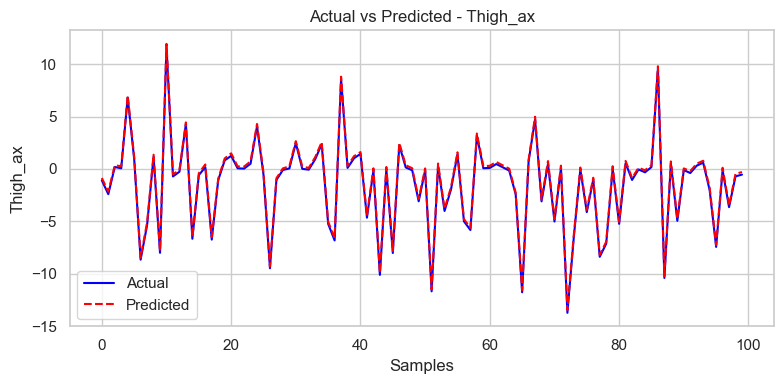

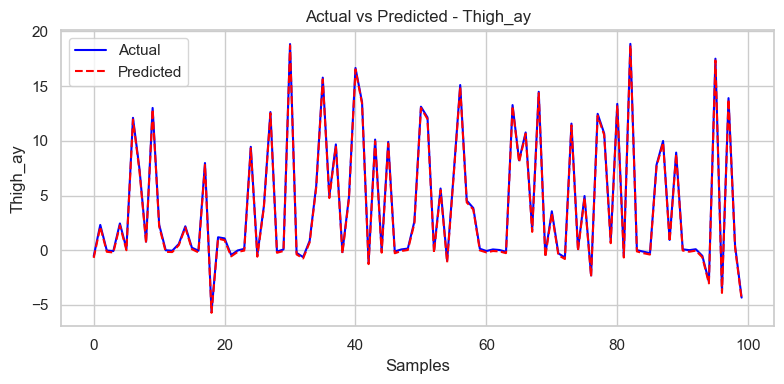

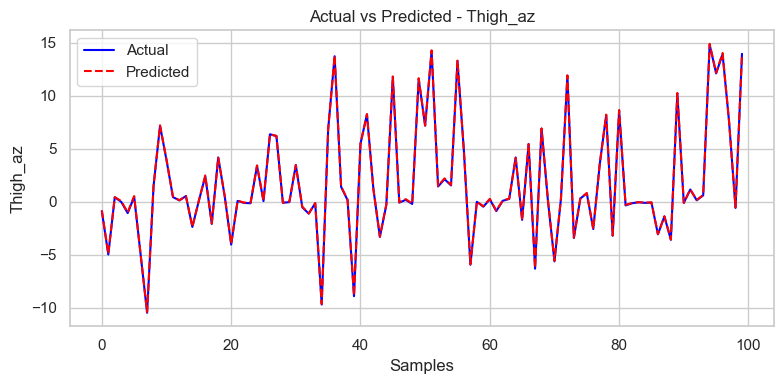

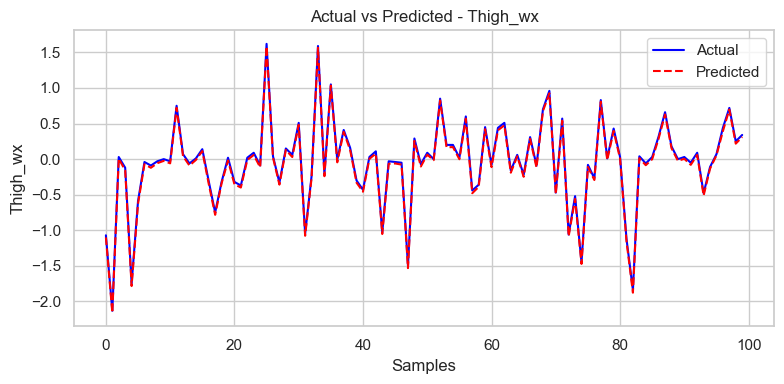

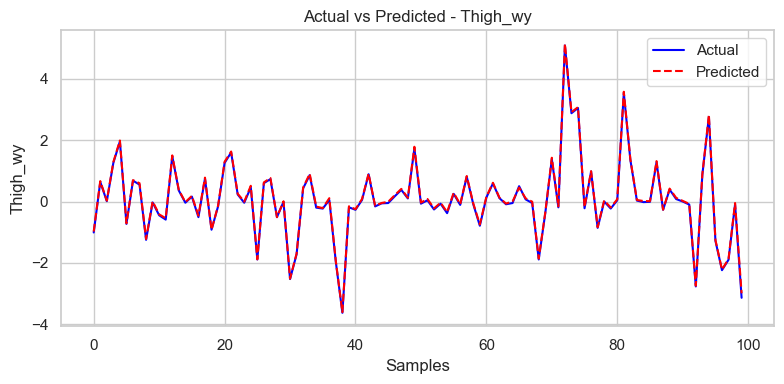

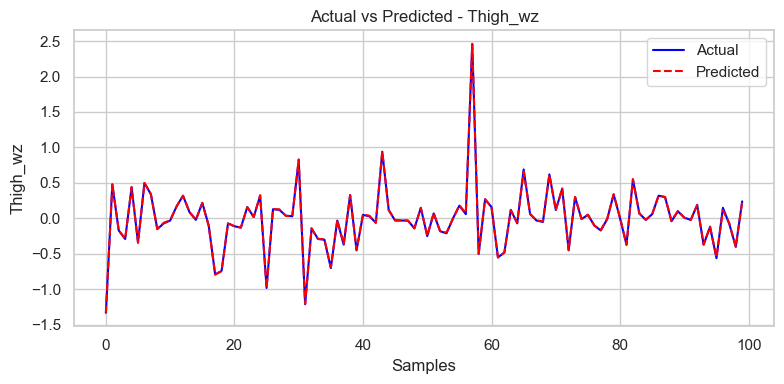

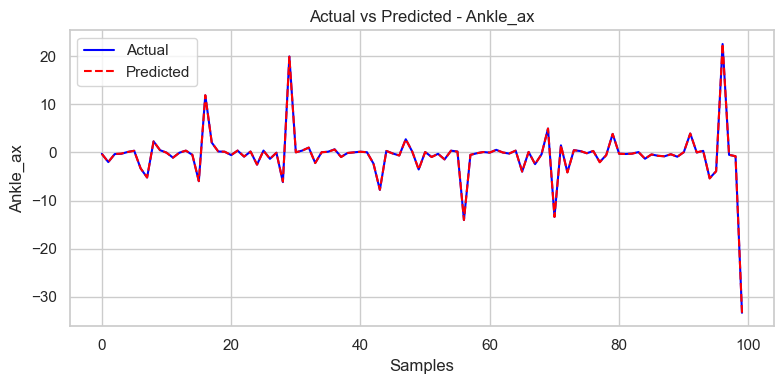

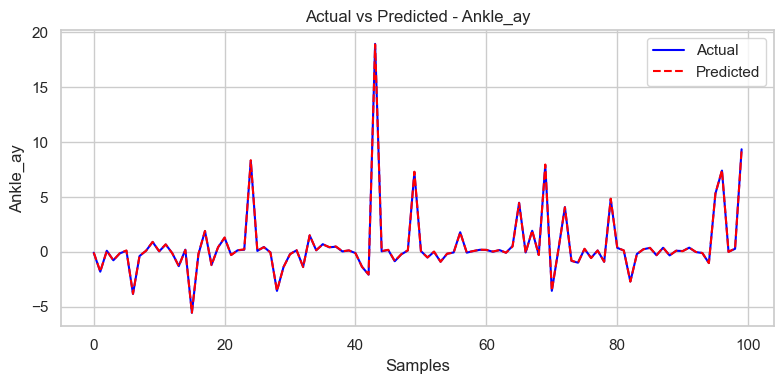

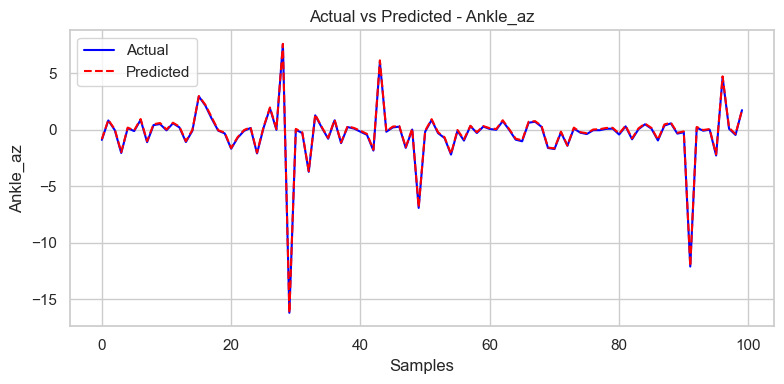

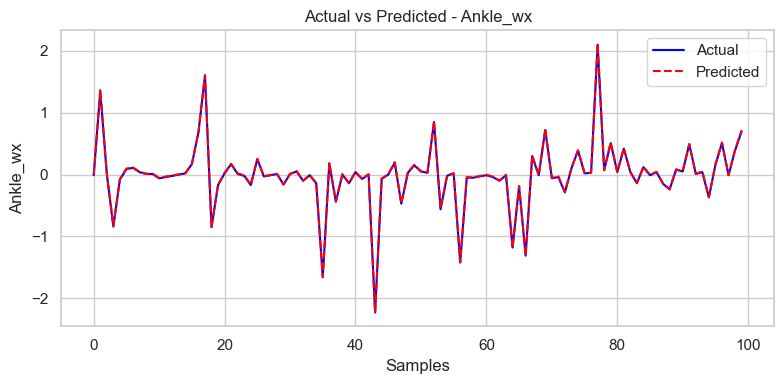

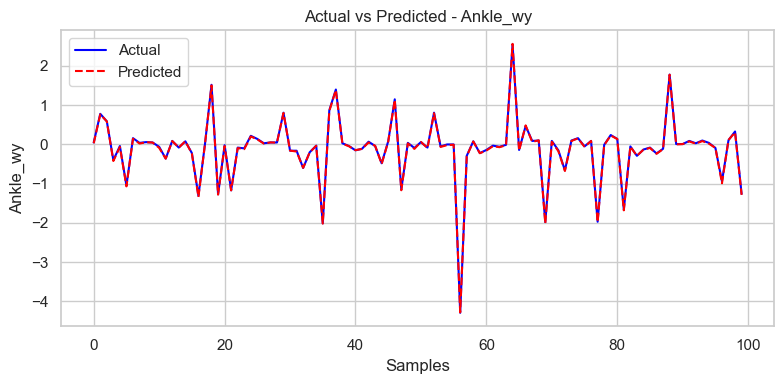

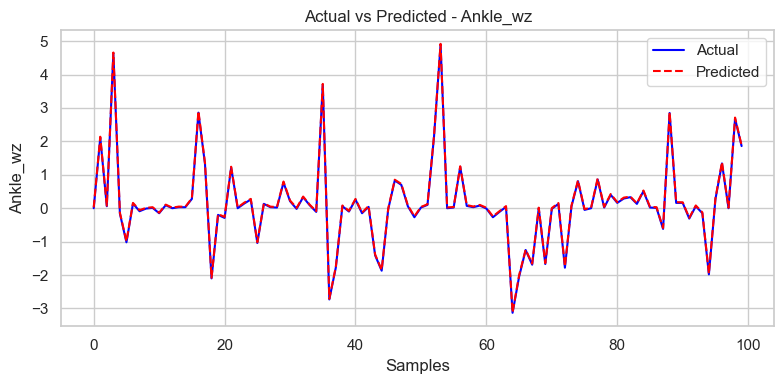

In [15]:
# GRU Regression Model for Multivariate Time Series Prediction

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Load dataset
df = pd.read_csv('Final_data_cleaned.csv')

# Feature and target columns
features = ["Speed_km_hr", "Volunteer", 
            "Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
            "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

targets = ["Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
           "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

X = df[features].values
y = df[targets].values

# Scale the data
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Reshape for GRU [samples, timesteps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# GRU model
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(len(targets))  # Output layer for multi-target regression
])

model.compile(optimizer='adam', loss='mse')
model.summary()


# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Save the trained model
model.save("GRU_sensor_model.h5")
print("Model saved successfully!")

# Predictions
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_inv = y_scaler.inverse_transform(y_test)

# Evaluation metrics
mse = mean_squared_error(y_test_inv, y_pred)
mae = mean_absolute_error(y_test_inv, y_pred)
r2 = r2_score(y_test_inv, y_pred)

print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plotting Actual vs Predicted for each target
for i, target in enumerate(targets):
    plt.figure(figsize=(8, 4))
    plt.plot(y_test_inv[:100, i], label='Actual', color='blue')
    plt.plot(y_pred[:100, i], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted - {target}')
    plt.xlabel('Samples')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Transformer Model
---

### Dataset Overview

- **Input Features (14)**:
  - Speed: `Speed_km_hr`
  - Subject ID: `Volunteer`
  - Thigh Sensor Data: `Thigh_ax`, `Thigh_ay`, `Thigh_az`, `Thigh_wx`, `Thigh_wy`, `Thigh_wz`
  - Ankle Sensor Data: `Ankle_ax`, `Ankle_ay`, `Ankle_az`, `Ankle_wx`, `Ankle_wy`, `Ankle_wz`

- **Target Variables (12)**:
  - Same set of Thigh and Ankle accelerometer and gyroscope signals as the input (excluding `Speed_km_hr` and `Volunteer`).

---

### Model Architecture

The proposed model leverages the Transformer Encoder architecture, which has shown exceptional capability in capturing complex relationships across structured input features.

#### Model Components

- **Input Linear Layer**:
  Projects the 14-dimensional input feature vector to a higher-dimensional latent space (`d_model = 64`).

  ```python
  self.input_linear = nn.Linear(input_dim, d_model)


C:\Users\rishi\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/15, Loss: 0.0259
Epoch 2/15, Loss: 0.0123
Epoch 3/15, Loss: 0.0067
Epoch 4/15, Loss: 0.0045
Epoch 5/15, Loss: 0.0030
Epoch 6/15, Loss: 0.0028
Epoch 7/15, Loss: 0.0032
Epoch 8/15, Loss: 0.0026
Epoch 9/15, Loss: 0.0026
Epoch 10/15, Loss: 0.0145
Epoch 11/15, Loss: 0.0059
Epoch 12/15, Loss: 0.0021
Epoch 13/15, Loss: 0.0014
Epoch 14/15, Loss: 0.0021
Epoch 15/15, Loss: 0.0019

Mean Squared Error (MSE): 0.0072
Mean Absolute Error (MAE): 0.0359
R-squared Score: 0.9976


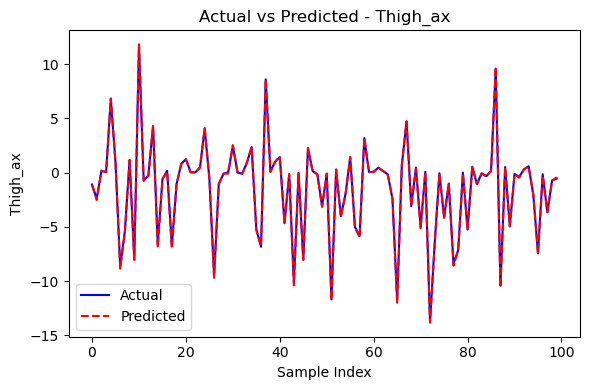

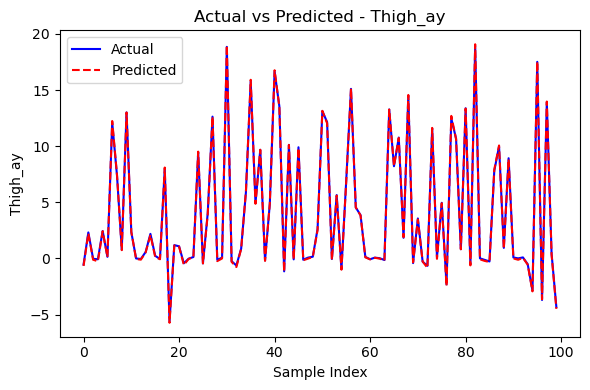

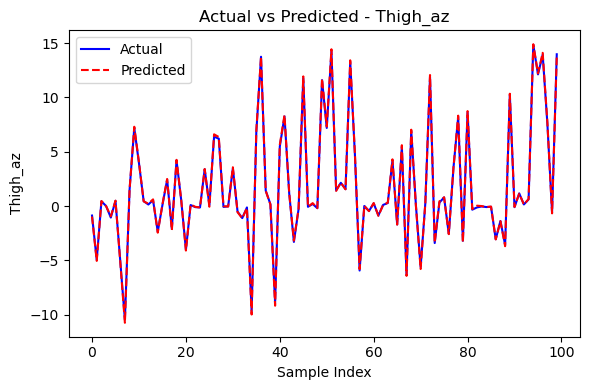

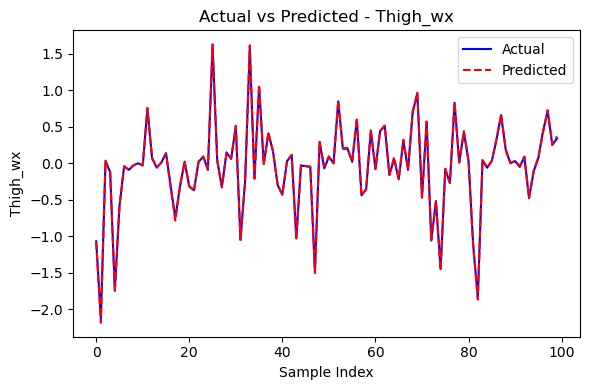

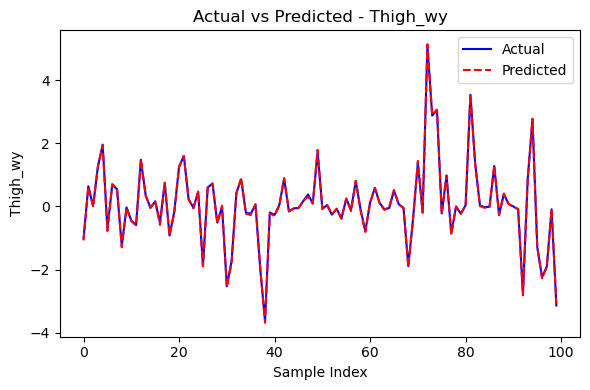

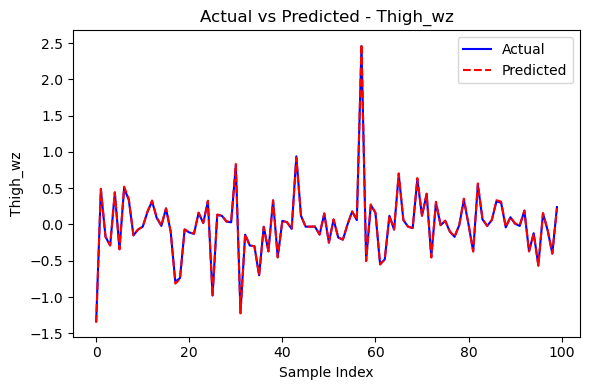

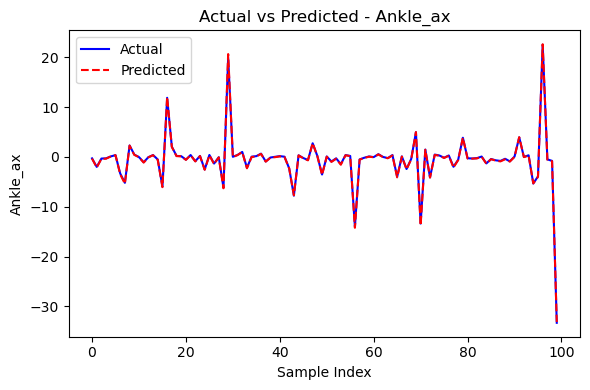

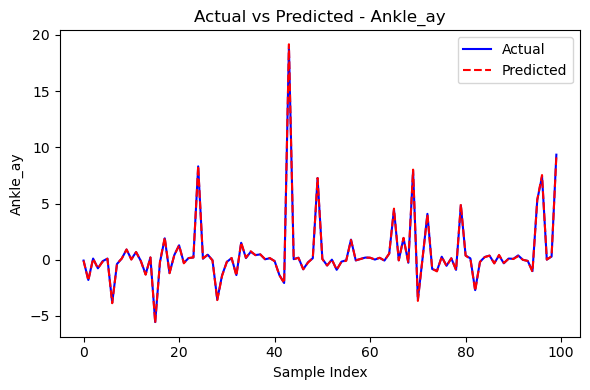

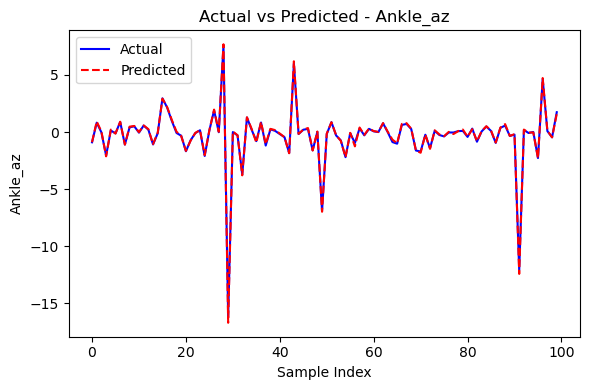

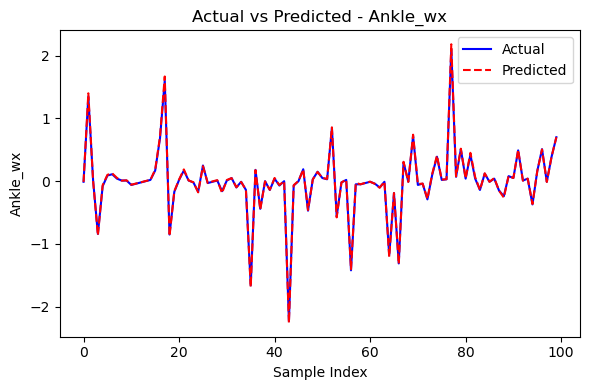

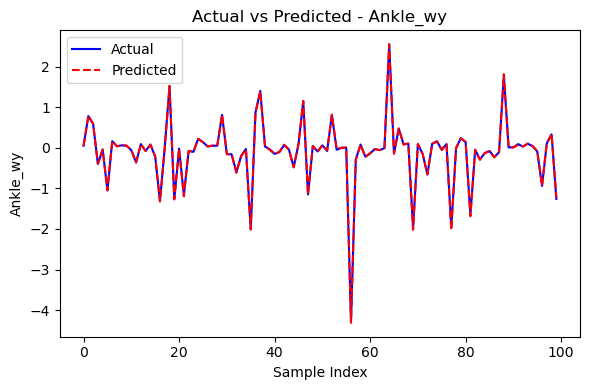

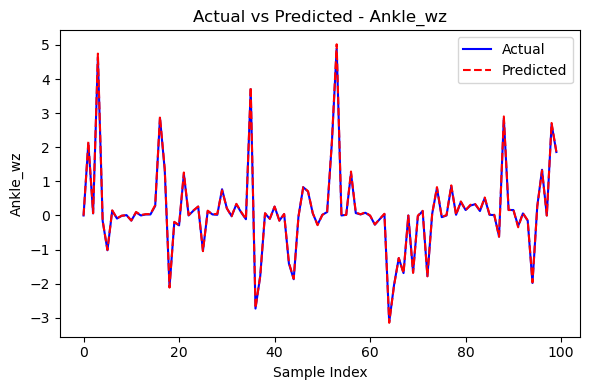

In [6]:
# Final_data_cleaned_Transformer_Model.ipynb

# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

# Step 2: Load dataset
df = pd.read_csv('Final_data_cleaned.csv')

# Step 3: Feature & Target Selection
features = ["Speed_km_hr", "Volunteer", 
            "Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
            "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

targets = ["Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
           "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

X = df[features]
y = df[targets]

# Step 4: Train/Test Split and Standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Step 5: Transformer Model for Regression
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.2):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_linear = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_linear(x).unsqueeze(1)  # (batch_size, seq_len=1, d_model)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        return self.output_linear(x)

# Step 6: Initialize Model, Loss, Optimizer
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = TransformerRegressor(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Training Loop
epochs = 15
model.train()
for epoch in range(epochs):
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Step 8: Evaluation
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_actual = scaler_y.inverse_transform(y_test_scaled)


# # Save the trained model
# model.save("transformer_sensor_model.h5")
# print("Model saved successfully!")

# Step 9: Metrics
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)
print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Step 10: Actual vs Predicted Plots for each target
for i, col in enumerate(targets):
    plt.figure(figsize=(6,4))
    plt.plot(y_actual[:100, i], label='Actual', color='blue')
    plt.plot(y_pred[:100, i], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted - {col}')
    plt.xlabel('Sample Index')
    plt.ylabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()


# GRU Model 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 14)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 30, 128)             │          55,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,324 (364.55 KB)

 Trainable params: 93,324 (364.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.0073 - val_loss: 7.2727e-04 - learning_rate: 0.0010
Epoch 2/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 2.8142e-04 - val_loss: 3.8082e-04 - learning_rate: 0.0010
Epoch 3/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 1.8845e-04 - val_loss: 3.5149e-04 - learning_rate: 0.0010
Epoch 4/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.8100e-04 - val_loss: 2.8592e-04 - learning_rate: 0.0010
Epoch 5/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 1.6355e-04 - val_loss: 2.6516e-04 - learning_rate: 0.0010
Epoch 6/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 1.5552e-04 - val_loss: 2.3642e-04 - learning_rate: 0.0010
Epoch 7/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 1.5526e-04 - val_loss: 2.4123e-04 - learning_rate: 0.0010
Epoch 8/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 1.5467e-04 - val_loss: 2.3019e-04 - learning_rate: 0.0010
Epoch 9/100
785/785 ━━━━━━━━━━━━━━━━

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean Squared Error (MSE): 0.4971
Mean Absolute Error (MAE): 0.2590
R² Score: 0.9545
Accuracy (thresholded): 0.9689
Precision (macro avg): 0.9589
Recall (macro avg): 0.9364
F1 Score (macro avg): 0.9472
Approx. Inference Time (1 sample): 1687107.24 ms


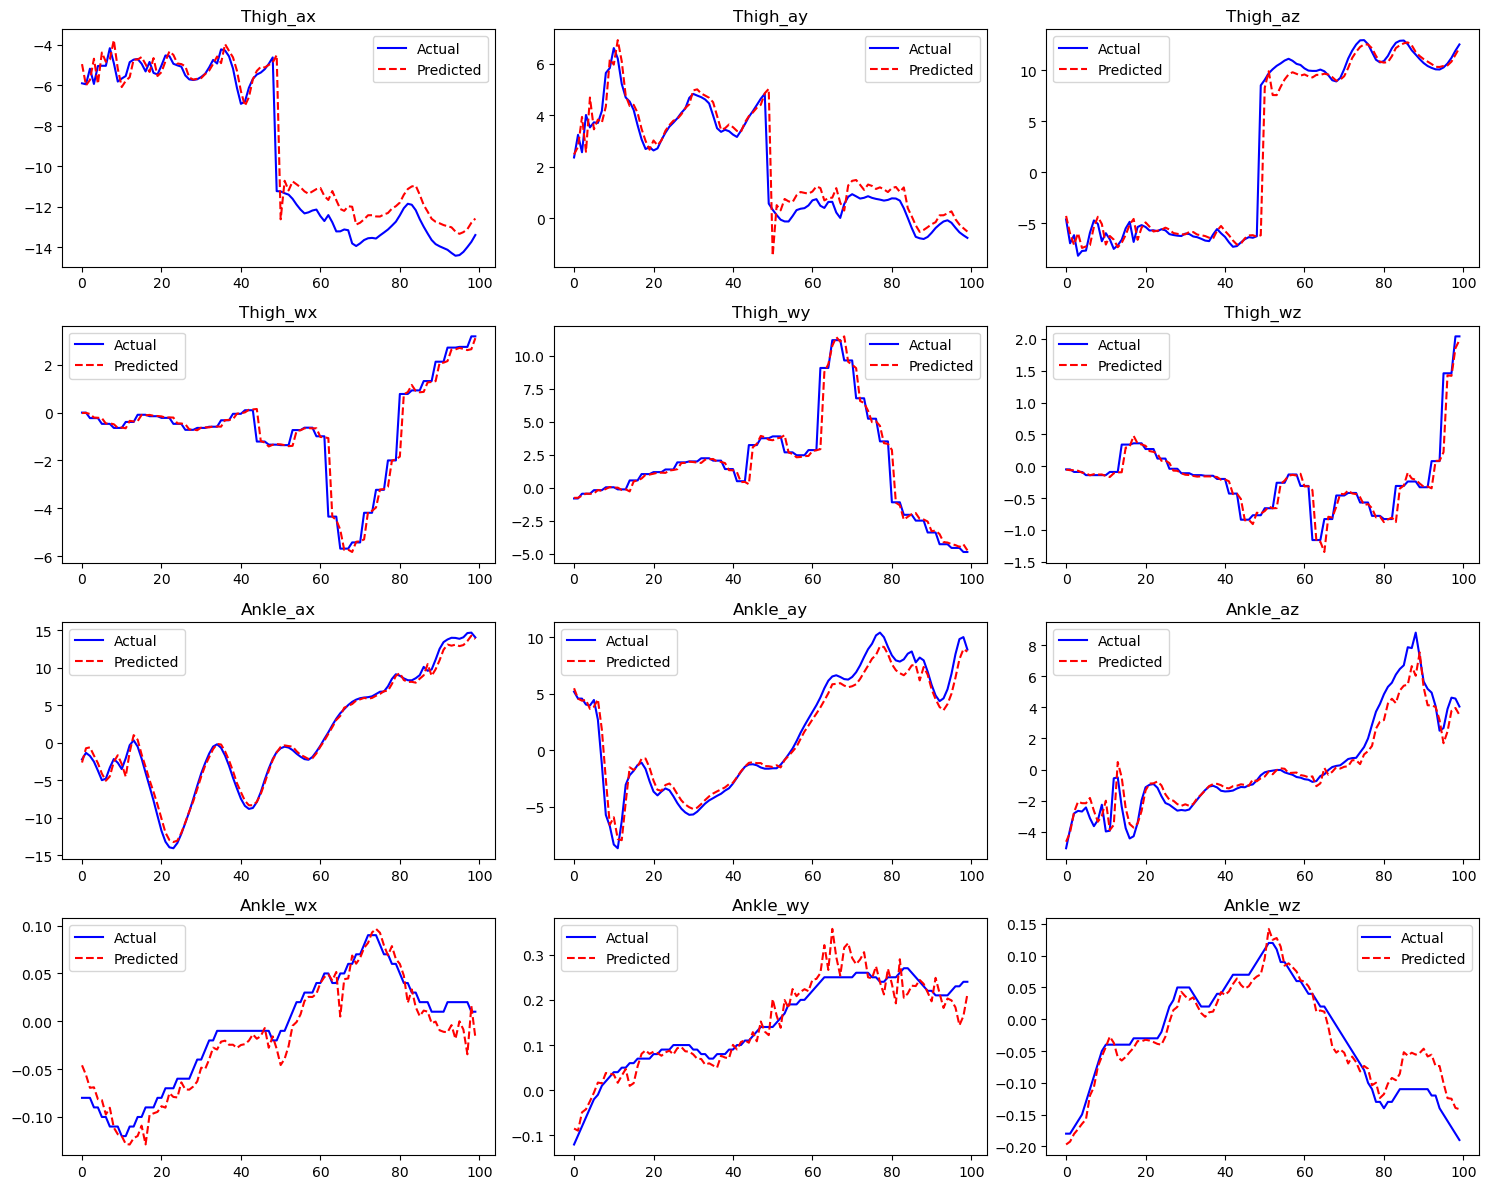

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import time

# Load your dataset
df = pd.read_csv("Final_data_cleaned.csv")

# Define features and targets
features = ["Speed_km_hr", "Volunteer", 
            "Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
            "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

targets = ["Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
           "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

# Scale data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
Y_scaled = scaler_Y.fit_transform(df[targets])

# Create sequences
seq_len = 30
X_seq, Y_seq = [], []
for i in range(len(df) - seq_len):
    X_seq.append(X_scaled[i:i+seq_len])
    Y_seq.append(Y_scaled[i+seq_len])
X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)

# Split data
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
Y_train, Y_test = Y_seq[:split], Y_seq[split:]

# Define GRU-based model
inputs = Input(shape=(seq_len, len(features)))
x = GRU(128, return_sequences=True)(inputs)
x = GRU(64)(x)
outputs = Dense(len(targets))(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

# Callbacks
lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train model
# Computational cost (inference time per sample)
start_time = time.time()
history = model.fit(X_train, Y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, Y_test), callbacks=[lr, es])

end_time = time.time()
inference_time = (end_time - start_time) * 1000  # in milliseconds

# Save model
model.save("gru_sensor_model.h5")

# Evaluate
Y_pred = model.predict(X_test)
Y_pred_actual = scaler_Y.inverse_transform(Y_pred)
Y_test_actual = scaler_Y.inverse_transform(Y_test)

mse = mean_squared_error(Y_test_actual, Y_pred_actual)
mae = mean_absolute_error(Y_test_actual, Y_pred_actual)
r2 = r2_score(Y_test_actual, Y_pred_actual)

# For classification-like metrics, we binarize the targets using a threshold
threshold = 0.5  # You can adjust this threshold as needed
Y_test_bin = (Y_test_actual > threshold).astype(int)
Y_pred_bin = (Y_pred_actual > threshold).astype(int)

# Compute metrics
precision = precision_score(Y_test_bin, Y_pred_bin, average='macro', zero_division=0)
recall = recall_score(Y_test_bin, Y_pred_bin, average='macro', zero_division=0)
f1 = f1_score(Y_test_bin, Y_pred_bin, average='macro', zero_division=0)
accuracy = accuracy_score(Y_test_bin.flatten(), Y_pred_bin.flatten())

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy (thresholded): {accuracy:.4f}")
print(f"Precision (macro avg): {precision:.4f}")
print(f"Recall (macro avg): {recall:.4f}")
print(f"F1 Score (macro avg): {f1:.4f}")
print(f"Approx. Inference Time (1 sample): {inference_time:.2f} ms")

# Plot predictions vs actual
plt.figure(figsize=(15, 12))
for i, label in enumerate(targets):
    plt.subplot(4, 3, i + 1)
    plt.plot(Y_test_actual[:100, i], label='Actual', color='blue')
    plt.plot(Y_pred_actual[:100, i], label='Predicted', color='red', linestyle='--')
    plt.title(label)
    plt.legend()
plt.tight_layout()
plt.show()


# Transformer Model 

Epoch 10, Loss: 0.3543
Epoch 20, Loss: 0.2010
Epoch 30, Loss: 0.1617
Epoch 40, Loss: 0.1371
Epoch 50, Loss: 0.1227
Epoch 60, Loss: 0.1131

Improved MAE: 0.1568
Improved MSE: 0.2140
Improved R^2 Score: 0.9523
Regression Accuracy (±0.1): 0.6581

--- Classification-style Metrics (Thigh_ax) ---
Confusion Matrix:
 [[4054  195]
 [  48 1986]]
Accuracy: 0.9613
Precision (Specificity Approx.): 0.9106
Recall (Sensitivity Approx.): 0.9764
F1 Score: 0.9423

--- Computational Cost ---
Prediction Time: 39.4569 seconds


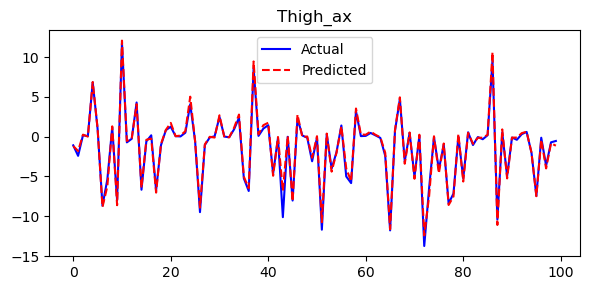

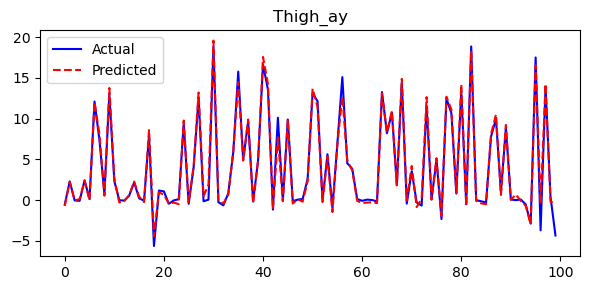

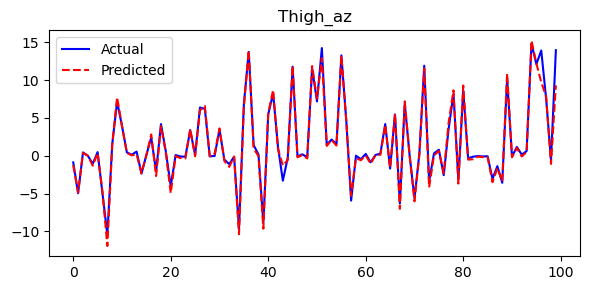

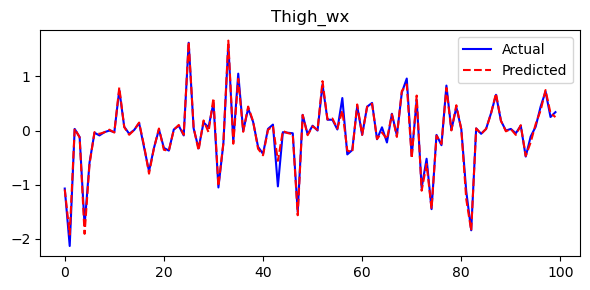

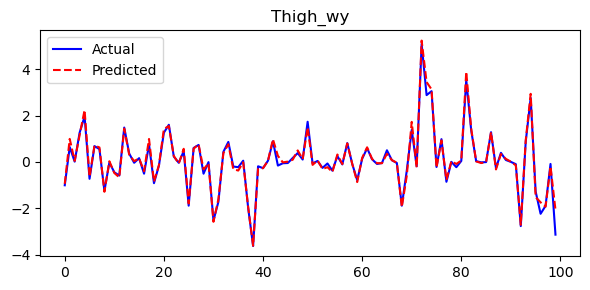

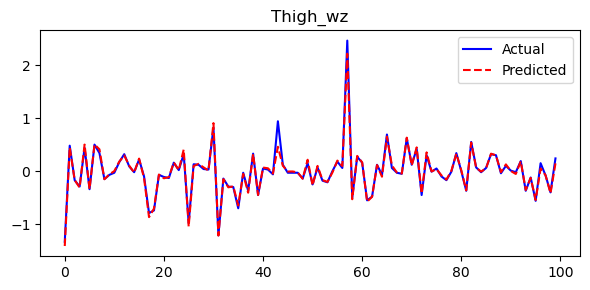

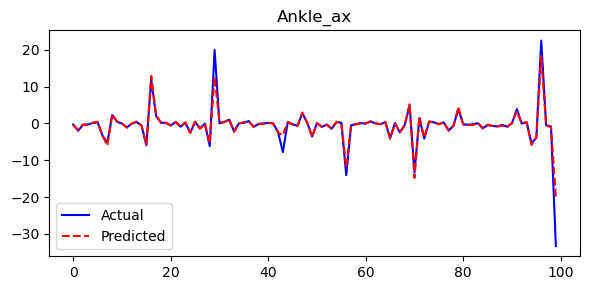

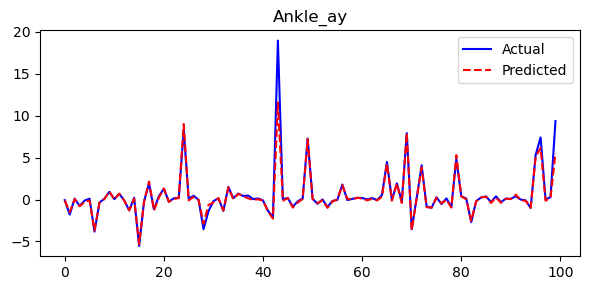

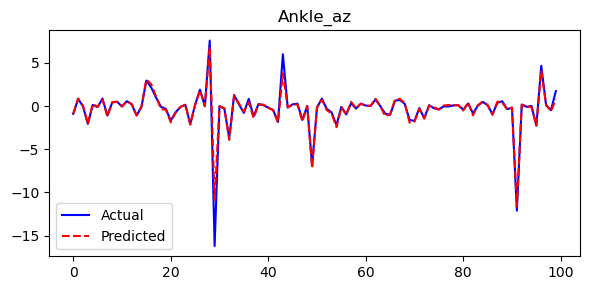

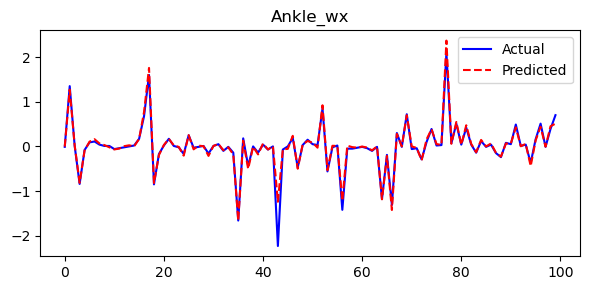

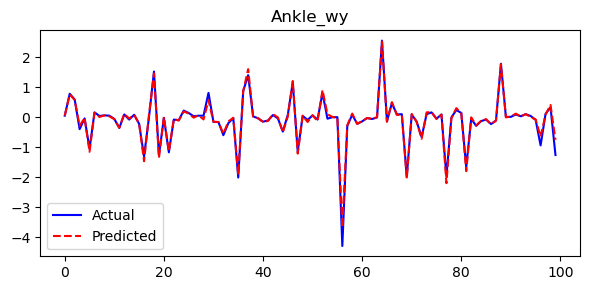

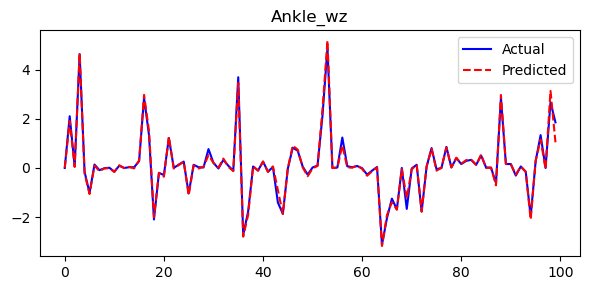

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import math
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Final_data_cleaned.csv")

# Define features and targets
features = ["Speed_km_hr", "Volunteer", 
            "Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
            "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

targets = ["Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
           "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

X = df[features].values
y = df[targets].values

# Normalize features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer Encoder Layer with Dropout and BatchNorm
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.ff = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

# Full Transformer Regressor Model
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, nhead, dropout) for _ in range(num_layers)
        ])
        self.output_proj = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=0)
        return self.output_proj(x)

# Model Parameters
model = TransformerRegressor(
    input_dim=len(features),
    d_model=128,
    nhead=8,
    num_layers=3,
    output_dim=len(targets),
    dropout=0.2
)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

# Start timing for computational cost
start_time = time.time()

# Training Loop
epochs = 60
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_tensor)
    loss = criterion(preds, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Computational Cost
end_time = time.time()
computational_cost = end_time - start_time

# Prediction
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).numpy()

# Inverse scale predictions
preds_inv = scaler_y.inverse_transform(preds)
y_test_inv = scaler_y.inverse_transform(y_test)

# Metrics
mae = mean_absolute_error(y_test_inv, preds_inv)
mse = mean_squared_error(y_test_inv, preds_inv)
r2 = r2_score(y_test_inv, preds_inv)

# Define a threshold for "correct prediction" for regression accuracy
tolerance = 0.1  # Adjust as needed
regression_accuracy = np.mean(np.abs(y_test_inv - preds_inv) < tolerance)

# Binarize outputs for classification-like metrics
# We'll use only one target output for demo purpose (e.g., Thigh_ax)
threshold = 0.5  # Adjust depending on normalized scale
y_true_bin = (y_test_inv[:, 0] > threshold).astype(int)
y_pred_bin = (preds_inv[:, 0] > threshold).astype(int)

conf_matrix = confusion_matrix(y_true_bin, y_pred_bin)
precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
acc = accuracy_score(y_true_bin, y_pred_bin)

print(f"\nImproved MAE: {mae:.4f}")
print(f"Improved MSE: {mse:.4f}")
print(f"Improved R^2 Score: {r2:.4f}")

print(f"Regression Accuracy (±{tolerance}): {regression_accuracy:.4f}")

print(f"\n--- Classification-style Metrics (Thigh_ax) ---")
print("Confusion Matrix:\n", conf_matrix)
print(f"Accuracy: {acc:.4f}")
print(f"Precision (Specificity Approx.): {precision:.4f}")
print(f"Recall (Sensitivity Approx.): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print(f"\n--- Computational Cost ---")
print(f"Prediction Time: {computational_cost:.4f} seconds")

# Plotting
for i, target in enumerate(targets):
    plt.figure(figsize=(6, 3))
    plt.plot(y_test_inv[:100, i], label="Actual", color='blue' )
    plt.plot(preds_inv[:100, i], label="Predicted", color='red', linestyle='--')
    plt.title(f"{target}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# CNN Model

Epoch 10, Loss: 0.3424
Epoch 20, Loss: 0.1928
Epoch 30, Loss: 0.1569
Epoch 40, Loss: 0.1340
Epoch 50, Loss: 0.1213
Epoch 60, Loss: 0.1123

--- Classification-like Metrics ---
Accuracy: 0.9931
Precision: 0.9929
Recall (Sensitivity): 0.9931
F1 Score: 0.9929

Improved MAE: 0.1584
Improved MSE: 0.2281
Improved R^2 Score: 0.9505
RMSE: 0.4776
Training Time (seconds): 32.37


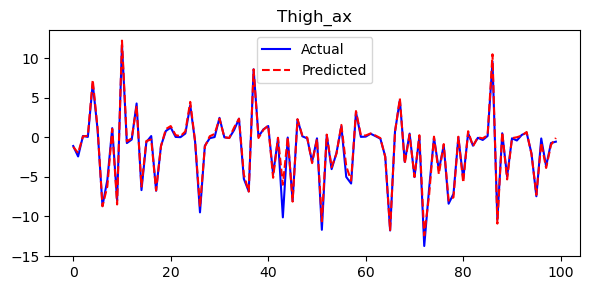

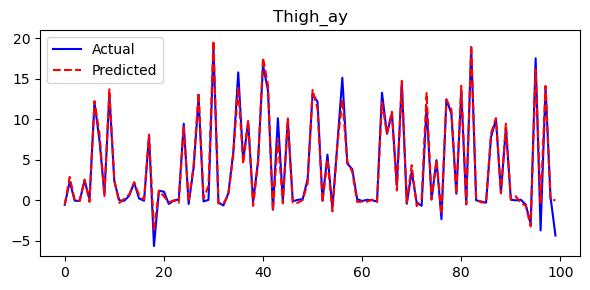

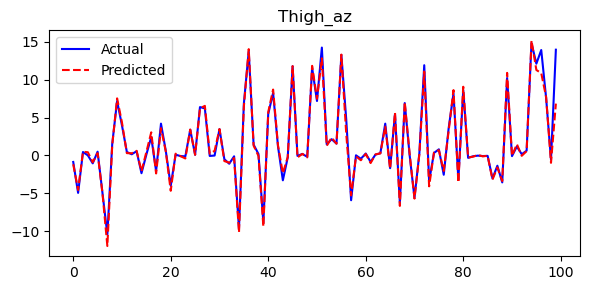

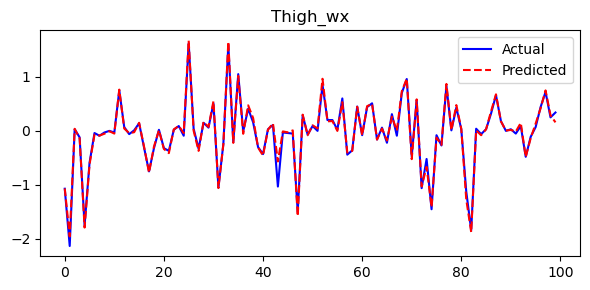

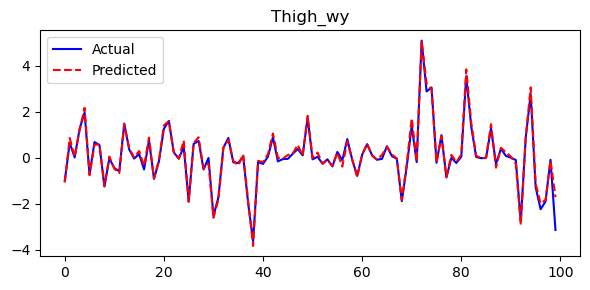

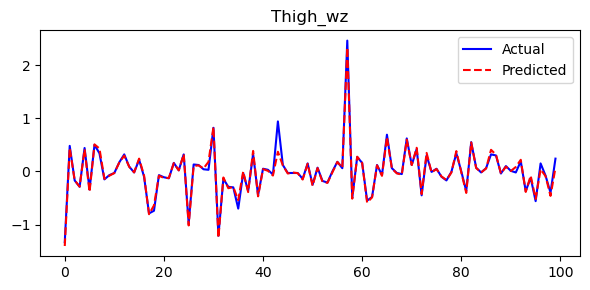

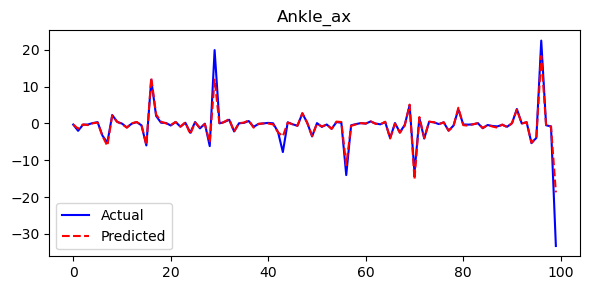

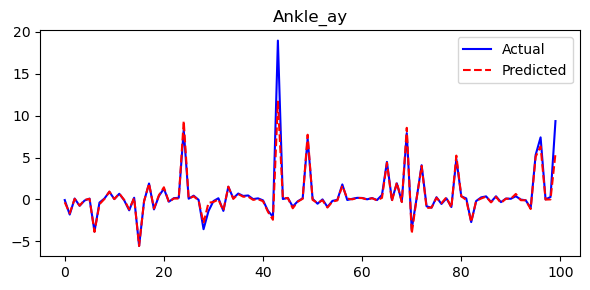

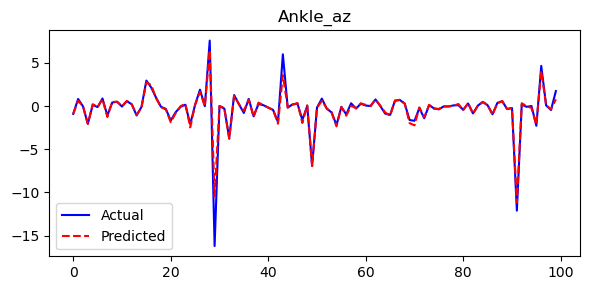

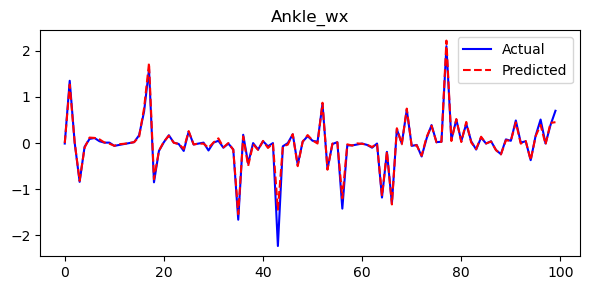

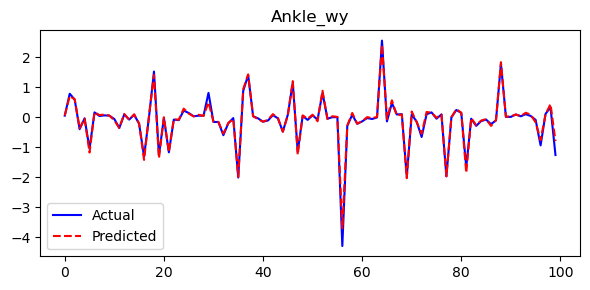

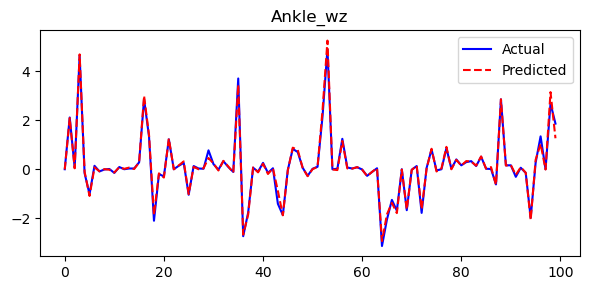

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time



# Load dataset
df = pd.read_csv("Final_data_cleaned.csv")

# Define features and targets
features = ["Speed_km_hr", "Volunteer", 
            "Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
            "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

targets = ["Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
           "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

X = df[features].values
y = df[targets].values

# Normalize features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer Encoder Layer with Dropout and BatchNorm
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.ff = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

# Full Transformer Regressor Model
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, nhead, dropout) for _ in range(num_layers)
        ])
        self.output_proj = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=0)
        return self.output_proj(x)

# Model Parameters
model = TransformerRegressor(
    input_dim=len(features),
    d_model=128,
    nhead=8,
    num_layers=3,
    output_dim=len(targets),
    dropout=0.2
)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

# Training Loop
epochs = 60

# Time the training process
start_time = time.time()

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_tensor)
    loss = criterion(preds, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

end_time = time.time()
training_time = end_time - start_time

# Prediction
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).numpy()

# Inverse scale predictions
preds_inv = scaler_y.inverse_transform(preds)
y_test_inv = scaler_y.inverse_transform(y_test)

# Metrics
mae = mean_absolute_error(y_test_inv, preds_inv)
mse = mean_squared_error(y_test_inv, preds_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, preds_inv)

# Example: bin outputs into 5 categories (just for illustration)
num_bins = 5
y_binned = np.digitize(y_test_inv.flatten(), bins=np.histogram_bin_edges(y_test_inv.flatten(), bins=num_bins))
pred_binned = np.digitize(preds_inv.flatten(), bins=np.histogram_bin_edges(y_test_inv.flatten(), bins=num_bins))

# Clip to ensure same bin range
y_binned = np.clip(y_binned, 0, num_bins-1)
pred_binned = np.clip(pred_binned, 0, num_bins-1)

# Compute classification metrics
accuracy = accuracy_score(y_binned, pred_binned)
precision = precision_score(y_binned, pred_binned, average='weighted', zero_division=0)
recall = recall_score(y_binned, pred_binned, average='weighted', zero_division=0)
f1 = f1_score(y_binned, pred_binned, average='weighted', zero_division=0)

print(f"\n--- Classification-like Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


print(f"\nImproved MAE: {mae:.4f}")
print(f"Improved MSE: {mse:.4f}")
print(f"Improved R^2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Training Time (seconds): {training_time:.2f}")

# Plotting
for i, target in enumerate(targets):
    plt.figure(figsize=(6, 3))
    plt.plot(y_test_inv[:100, i], label="Actual", color='blue' )
    plt.plot(preds_inv[:100, i], label="Predicted", color='red', linestyle='--')
    plt.title(f"{target}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Radial Basis Function Neural Network (RBFNN) Model

Epoch 10, Loss: 0.9932
Epoch 20, Loss: 0.9556
Epoch 30, Loss: 0.8399
Epoch 40, Loss: 0.5227
Epoch 50, Loss: 0.4047
Epoch 60, Loss: 0.3454
Epoch 70, Loss: 0.2963
Epoch 80, Loss: 0.2688
Epoch 90, Loss: 0.2445
Epoch 100, Loss: 0.2236
Epoch 110, Loss: 0.2061
Epoch 120, Loss: 0.1910
Epoch 130, Loss: 0.1786
Epoch 140, Loss: 0.1671
Epoch 150, Loss: 0.1573
Epoch 160, Loss: 0.1488
Epoch 170, Loss: 0.1439
Epoch 180, Loss: 0.1353
Epoch 190, Loss: 0.1299
Epoch 200, Loss: 0.1248
Epoch 210, Loss: 0.1200
Epoch 220, Loss: 0.1169
Epoch 230, Loss: 0.1121
Epoch 240, Loss: 0.1097
Epoch 250, Loss: 0.1074
Epoch 260, Loss: 0.1027
Epoch 270, Loss: 0.1031
Epoch 280, Loss: 0.0990
Epoch 290, Loss: 0.0966
Epoch 300, Loss: 0.0933
Epoch 310, Loss: 0.0962
Epoch 320, Loss: 0.0891
Epoch 330, Loss: 0.0881
Epoch 340, Loss: 0.0855
Epoch 350, Loss: 0.0883
Epoch 360, Loss: 0.0832
Epoch 370, Loss: 0.0811
Epoch 380, Loss: 0.0837
Epoch 390, Loss: 0.0785
Epoch 400, Loss: 0.0780
Epoch 410, Loss: 0.0805
Epoch 420, Loss: 0.0756
E

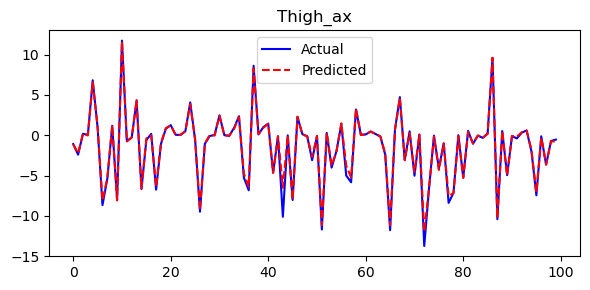

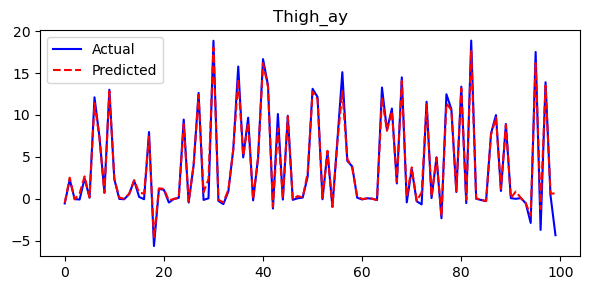

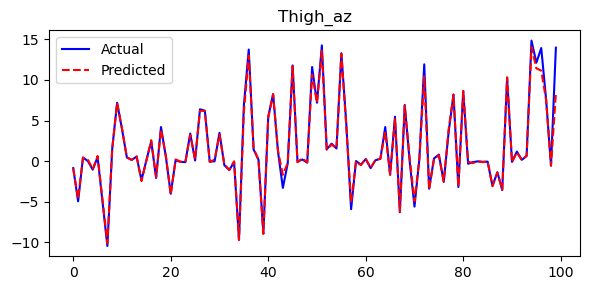

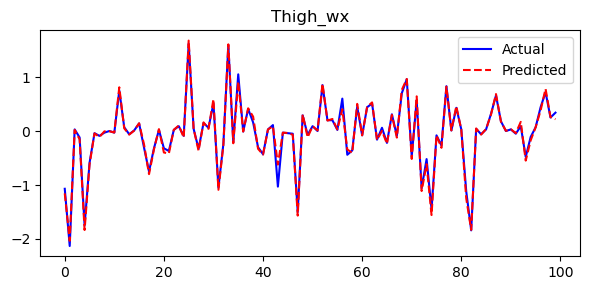

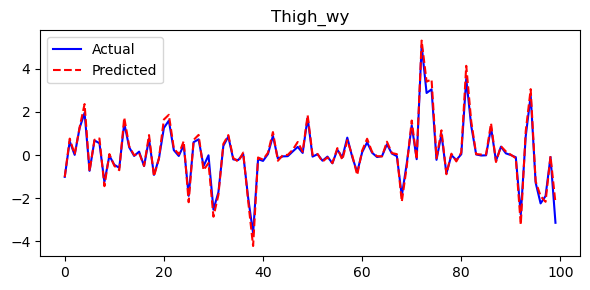

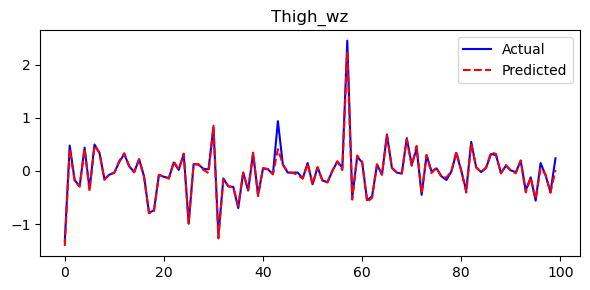

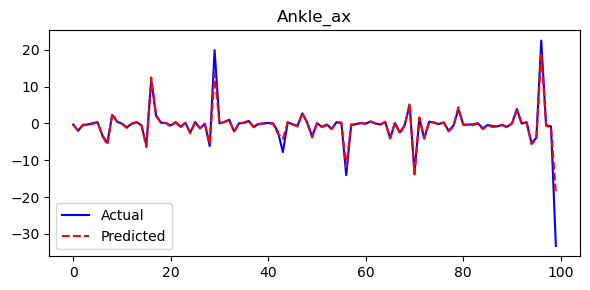

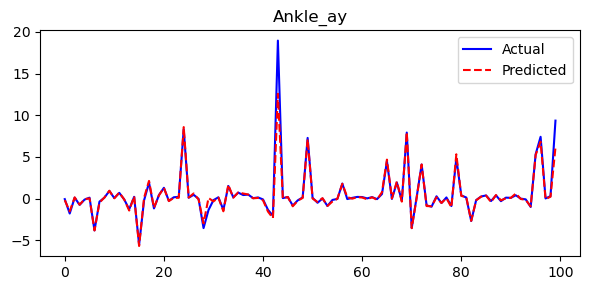

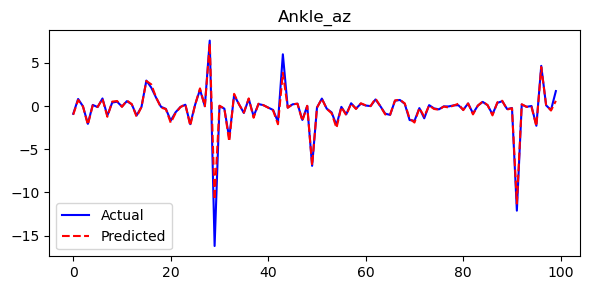

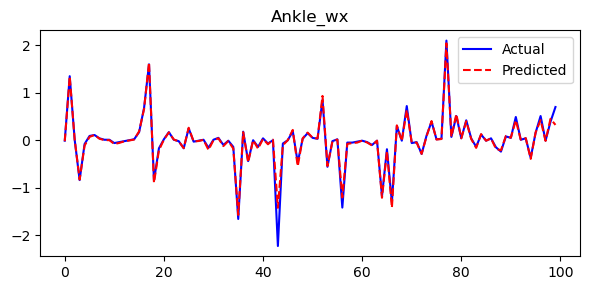

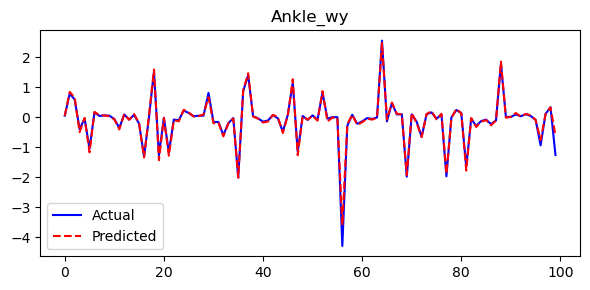

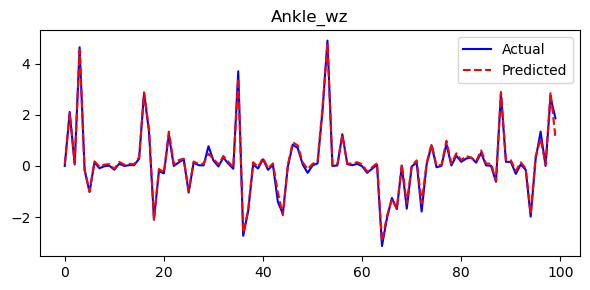

In [22]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

# Load dataset
df = pd.read_csv("Final_data_cleaned.csv")

# Define features and targets
features = ["Speed_km_hr", "Volunteer",
            "Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
            "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

targets = ["Thigh_ax", "Thigh_ay", "Thigh_az", "Thigh_wx", "Thigh_wy", "Thigh_wz",
           "Ankle_ax", "Ankle_ay", "Ankle_az", "Ankle_wx", "Ankle_wy", "Ankle_wz"]

X = df[features].values
y = df[targets].values

# Normalize features and targets
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define RBF Layer
class RBFLayer(nn.Module):
    def __init__(self, in_features, out_features, beta=1.0):
        super(RBFLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centers = nn.Parameter(torch.randn(out_features, in_features))
        self.beta = nn.Parameter(torch.tensor(beta))

    def forward(self, x):
        x = x.unsqueeze(1)  # shape: [batch_size, 1, in_features]
        c = self.centers.unsqueeze(0)  # shape: [1, out_features, in_features]
        dist = torch.norm(x - c, dim=2)  # shape: [batch_size, out_features]
        return torch.exp(-self.beta * dist ** 2)

# Define full RBFNN model
class RBFNN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, beta=1.0):
        super(RBFNN, self).__init__()
        self.rbf = RBFLayer(in_features, hidden_features, beta)
        self.linear = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.rbf(x)
        return self.linear(x)

# Model configuration
model = RBFNN(
    in_features=X_train_tensor.shape[1],
    hidden_features=100,  # you can tune this
    out_features=y_train_tensor.shape[1],
    beta=0.5  # you can tune this
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 500
start_time = time.time()

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_tensor)
    loss = criterion(preds, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

training_time = time.time() - start_time

# Evaluation
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).numpy()

preds_inv = scaler_y.inverse_transform(preds)
y_test_inv = scaler_y.inverse_transform(y_test)

# Regression Metrics
mae = mean_absolute_error(y_test_inv, preds_inv)
mse = mean_squared_error(y_test_inv, preds_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, preds_inv)

# Binned classification metrics (illustrative)
num_bins = 5
y_binned = np.digitize(y_test_inv.flatten(), bins=np.histogram_bin_edges(y_test_inv.flatten(), bins=num_bins))
pred_binned = np.digitize(preds_inv.flatten(), bins=np.histogram_bin_edges(y_test_inv.flatten(), bins=num_bins))

y_binned = np.clip(y_binned, 0, num_bins - 1)
pred_binned = np.clip(pred_binned, 0, num_bins - 1)

accuracy = accuracy_score(y_binned, pred_binned)
precision = precision_score(y_binned, pred_binned, average='weighted', zero_division=0)
recall = recall_score(y_binned, pred_binned, average='weighted', zero_division=0)
f1 = f1_score(y_binned, pred_binned, average='weighted', zero_division=0)

print(f"\n--- Classification-like Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print(f"\nMAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Training Time (seconds): {training_time:.2f}")

# Plot Predictions
for i, target in enumerate(targets):
    plt.figure(figsize=(6, 3))
    plt.plot(y_test_inv[:100, i], label="Actual", color='blue')
    plt.plot(preds_inv[:100, i], label="Predicted", color='red', linestyle='--')
    plt.title(f"{target}")
    plt.legend()
    plt.tight_layout()
    plt.show()
